In [2]:
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sys.path.insert(0, "../src/")
from Decomposed_matrices import Decomposed_matrices
from Genomic_bins import Genomic_bins
from great import read_great_res_wrapper

### Load Data Matrices

In [63]:
data_dir = '../private_data'

genomic_bins = Genomic_bins(os.path.join(data_dir, 'loci_def.bed'))
decomposed_mats = Decomposed_matrices(os.path.join(data_dir, 'diagonalScore.csv.gz'), os.path.join(data_dir, 'uScore.csv.gz'), os.path.join(data_dir, 'vScore.csv.gz'))

### Output from SNP2CHIP on SNP Catalog

Load results form SNP2ChIP.

In [5]:
input_dir = '../src/snp_scan.csv'
input_err_dir = '../src/snp_scan_err.csv'

snps_output_df = pd.read_csv(input_dir, sep=',', header=None, names=['CHR','LOC','K','PCs','SCORES','PHENOTYPE','TYPE','INTERGENIC'])
snps_error_df = pd.read_csv(input_err_dir, sep=',', header=None, names=['CHR','LOC','K','PHENOTYPE','TYPE','INTERGENIC'])

In [3]:
input_corr_dir = '../src/corr_snp_scan.csv'
input_corr_err_dir = '../src/corr_snp_scan_err.csv'

corr_output_df = pd.read_csv(input_corr_dir, sep=',', header=None, names=['CHR','LOC','K','PCs','SCORES','PHENOTYPE','TYPE','INTERGENIC'])
corr_error_df = pd.read_csv(input_corr_err_dir, sep=',', header=None, names=['CHR','LOC','K','PHENOTYPE','TYPE','INTERGENIC'])

In [6]:
print(int(100*snps_output_df.shape[0]/snps_error_df.shape[0]),"% SNPs passed through snp2chip")

21 % SNPs passed through snp2chip


In [7]:
print(int(100*corr_output_df.shape[0]/corr_error_df.shape[0]),"% SNPs passed through snp2chip")

21 % SNPs passed through snp2chip


In [219]:
def list_fun(s):
    res = []
    for sval in s[1:-2].split(' '):
        try: 
            res.append(int(sval))
        except:
            continue
    return res

In [224]:
snps_output_df['top_pc'] = snps_output_df.apply(lambda x: list_fun(x['PCs'])[0], axis=1)
snps_output_df['sec_pc'] = snps_output_df.apply(lambda x: list_fun(x['PCs'])[1], axis=1)

In [235]:
list(snps_output_df)

['CHR',
 'LOC',
 'K',
 'PCs',
 'SCORES',
 'PHENOTYPE',
 'TYPE',
 'INTERGENIC',
 'top_pc',
 'sec_pc']

### Get Top Counts of each Phenotype

In [253]:
phen_df = snps_output_df.groupby('PHENOTYPE').size().to_frame().sort_values(0, ascending=False).rename(columns={0:'reg_count'})
phen_err_df = snps_error_df.groupby('PHENOTYPE').size().to_frame().sort_values(0, ascending=False).rename(columns={0:'err_count'})
full_phenotype_df = phen_err_df.join(phen_df)

full_phenotype_df.head()

,err_count,reg_count
PHENOTYPE,,
Blood protein levels,2012,545.0
Body mass index,904,142.0
Post bronchodilator FEV1/FVC ratio,878,173.0
Post bronchodilator FEV1,729,151.0
Schizophrenia,611,119.0


### Compute Fraction of Phenotype SNP Coverage in SNPs2ChIP

The ``frac`` indicates the number of SNPs that SNPs2ChIP currently covers. We filter for phenotypes sorted by the highest fraction coverage above 25 catalogued and reported in SNPs2ChIP. 

In [254]:
full_phenotype_df['frac'] = full_phenotype_df.apply(lambda x: x['reg_count'] / x.sum(), axis=1)
full_phenotype_df = full_phenotype_df.sort_values('frac', ascending=False)
full_phenotype_df.head()

,err_count,reg_count,frac
PHENOTYPE,,,
Ovarian cancer in BRCA1 mutation carriers,1,5.0,0.833333
Skin colour saturation,1,4.0,0.800000
Myositis,1,4.0,0.800000
IgG bisecting N-acetyl glucosamine phenotypes (multivariate analysis),1,3.0,0.750000
IgG disialylation phenotypes (multivariate analysis),1,3.0,0.750000


In [255]:
phenotypes_of_interest = full_phenotype_df[full_phenotype_df['reg_count'] > 25].head(15).index.values

Text(0.5,1,'SNPs Found per Phenotype')

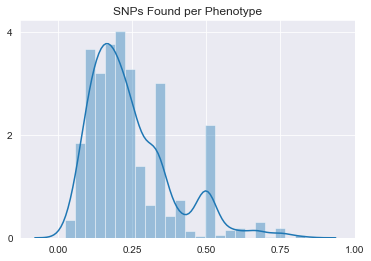

In [423]:
hist_df = full_phenotype_df.fillna(value=0)
ax = sns.distplot(hist_df[hist_df['frac'] > 0]['frac'])
ax.set_xlabel('')
ax.set_xticks((0,0.25,0.5,0.75,1))
ax.set_yticks((0,2,4))
ax.set_title('SNPs Found per Phenotype')

[Text(0,0.5,'Found SNPs'), Text(0.5,0,'Missed SNPs')]

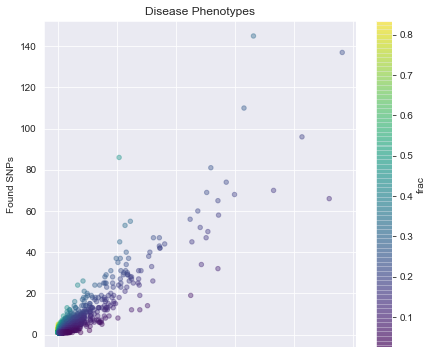

In [267]:
sns.set_style("darkgrid")

ax = full_phenotype_df[full_phenotype_df['err_count'] < 500].rename(columns={'err_count': 'Missed SNPs', 'reg_count': 'Found SNPs'}).plot.scatter(x='Missed SNPs',
                     y='Found SNPs', c='frac', colormap='viridis', figsize=(7,6), alpha=0.4)
ax.set_title('Disease Phenotypes')
ax.set(xlabel='Missed SNPs', ylabel='Found SNPs')

In [403]:
def get_top_pcs(phenotype, verbose=True):
    """
    Takes in a phenotype from GWAS catalogue and returns the top pcs and scores. 
    """
    chrs = snps_output_df[snps_output_df['PHENOTYPE'] == phenotype]['CHR'].values
    snps = snps_output_df[snps_output_df['PHENOTYPE'] == phenotype]['LOC'].values
    pcs, scores = decomposed_mats.find_pcs_given_loci_list(genomic_bins.find_loci_given_snps(list(chrs), list(snps)))
    
    if verbose:
        print('Phenotype: ', phenotype)
        print("Top PCs: ", pcs)

    return pcs, scores

def get_enrichment(pc):
    """
    Gets enrichment results from GREAT wrapper. Computes neg. log p-value.
    """
    res = read_great_res_wrapper(data_dir, pc, 'HumanPhenotypeOntology', topk=10)
    res['neg_log_p'] = res.apply(lambda x: -np.log(x['BPval']), axis=1)
    return res

import matplotlib.cm as cm
import matplotlib.colors as mcolors

def plot_enrichment_fig(res):
    """
    Creates enrichment result plots from output of get_enrichment.
    """
    fig  = plt.figure(figsize=(8,4),  dpi=300)
    pal = sns.color_palette("Blues_d", n_colors=res.shape[0], desat=1)
    rank = res['BFold'].values.argsort()

    ax = sns.barplot(x='neg_log_p', y='# ID', data=res,
               palette=np.array(pal[::-1])[rank])
    ax.set_xlabel('-log(p-value)')
    ax.set_ylabel('')

    rects = ax.patches

    # Make some labels.
    labels = res['Desc'].values

    for rect, label in zip(rects, labels):
        x_value = rect.get_width()
        y_value = rect.get_y() + rect.get_height() / 2

        space = -5
        ha = 'right'

        #label = "{:.1f}".format(x_value)
        plt.annotate(
            label,                      
            (x_value, y_value),         
            xytext=(space, 0),          
            textcoords="offset points", 
            va='center',                
            ha=ha,
            color='white')  

    normalize = mcolors.Normalize(vmin=res['BFold'].values.min(), vmax=res['BFold'].values.max())
    colormap = cm.Blues
    scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
    scalarmappaple.set_array(10)
    plt.colorbar(scalarmappaple, label='Binom. Fold')

### Investigate Enrichment of Each Phenotype's Top PCs

In [248]:
# pc_list = []

# for phen in phenotypes_of_interest:
#     pcs, scores = get_top_pcs(phen)
    
# top_phen_df = snps_output_df[snps_output_df['PHENOTYPE'].isin(phenotypes_of_interest[:3])]
# sns.scatterplot(data=top_phen_df, x='top_pc', y='sec_pc', hue='PHENOTYPE', alpha=0.4)

Phenotype:  IgG glycosylation patterns
Top PCs:  [22 19 24 16 11]


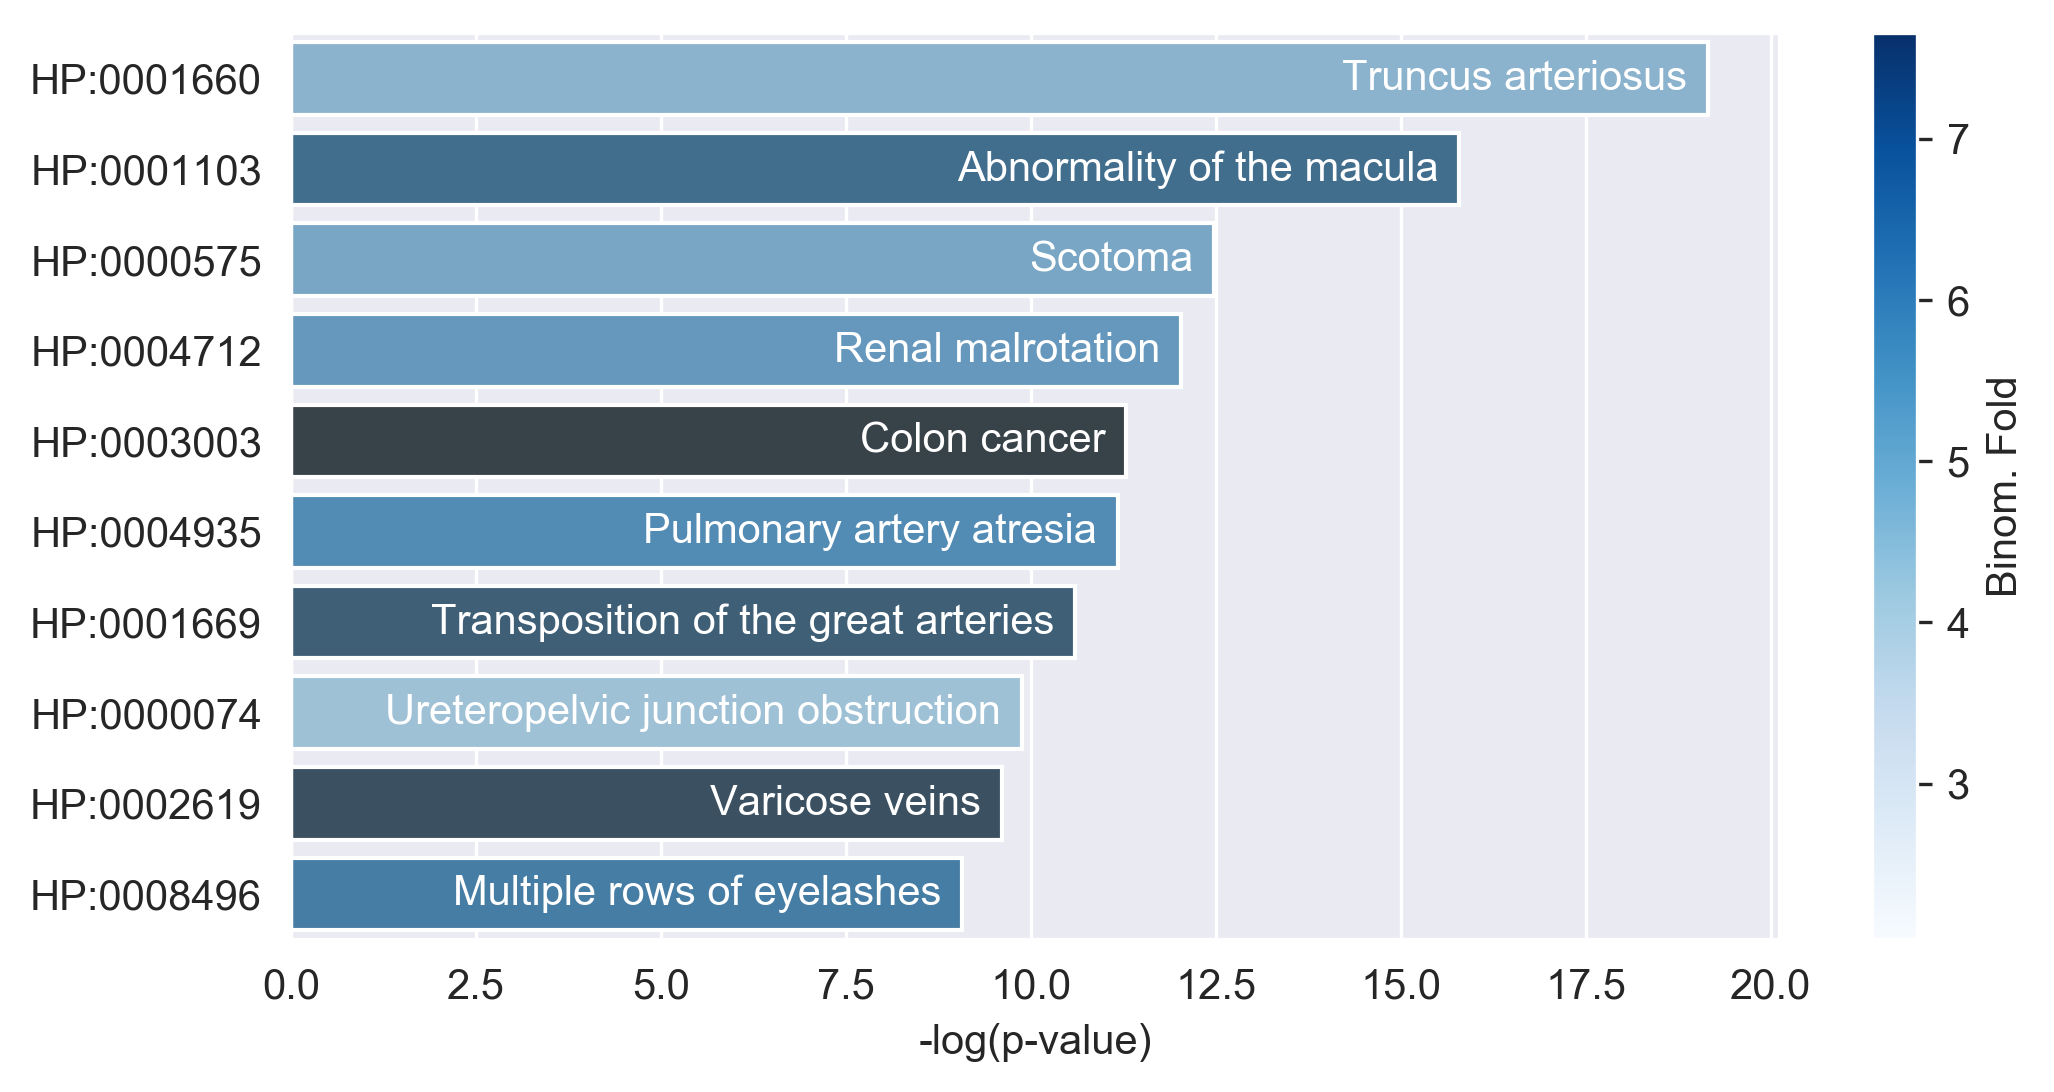

In [388]:
res = get_enrichment(get_top_pcs(phenotypes_of_interest[0])[0][0])
plot_enrichment_fig(res)

Phenotype:  Vitiligo
Top PCs:  [  2   0   3 280   1]


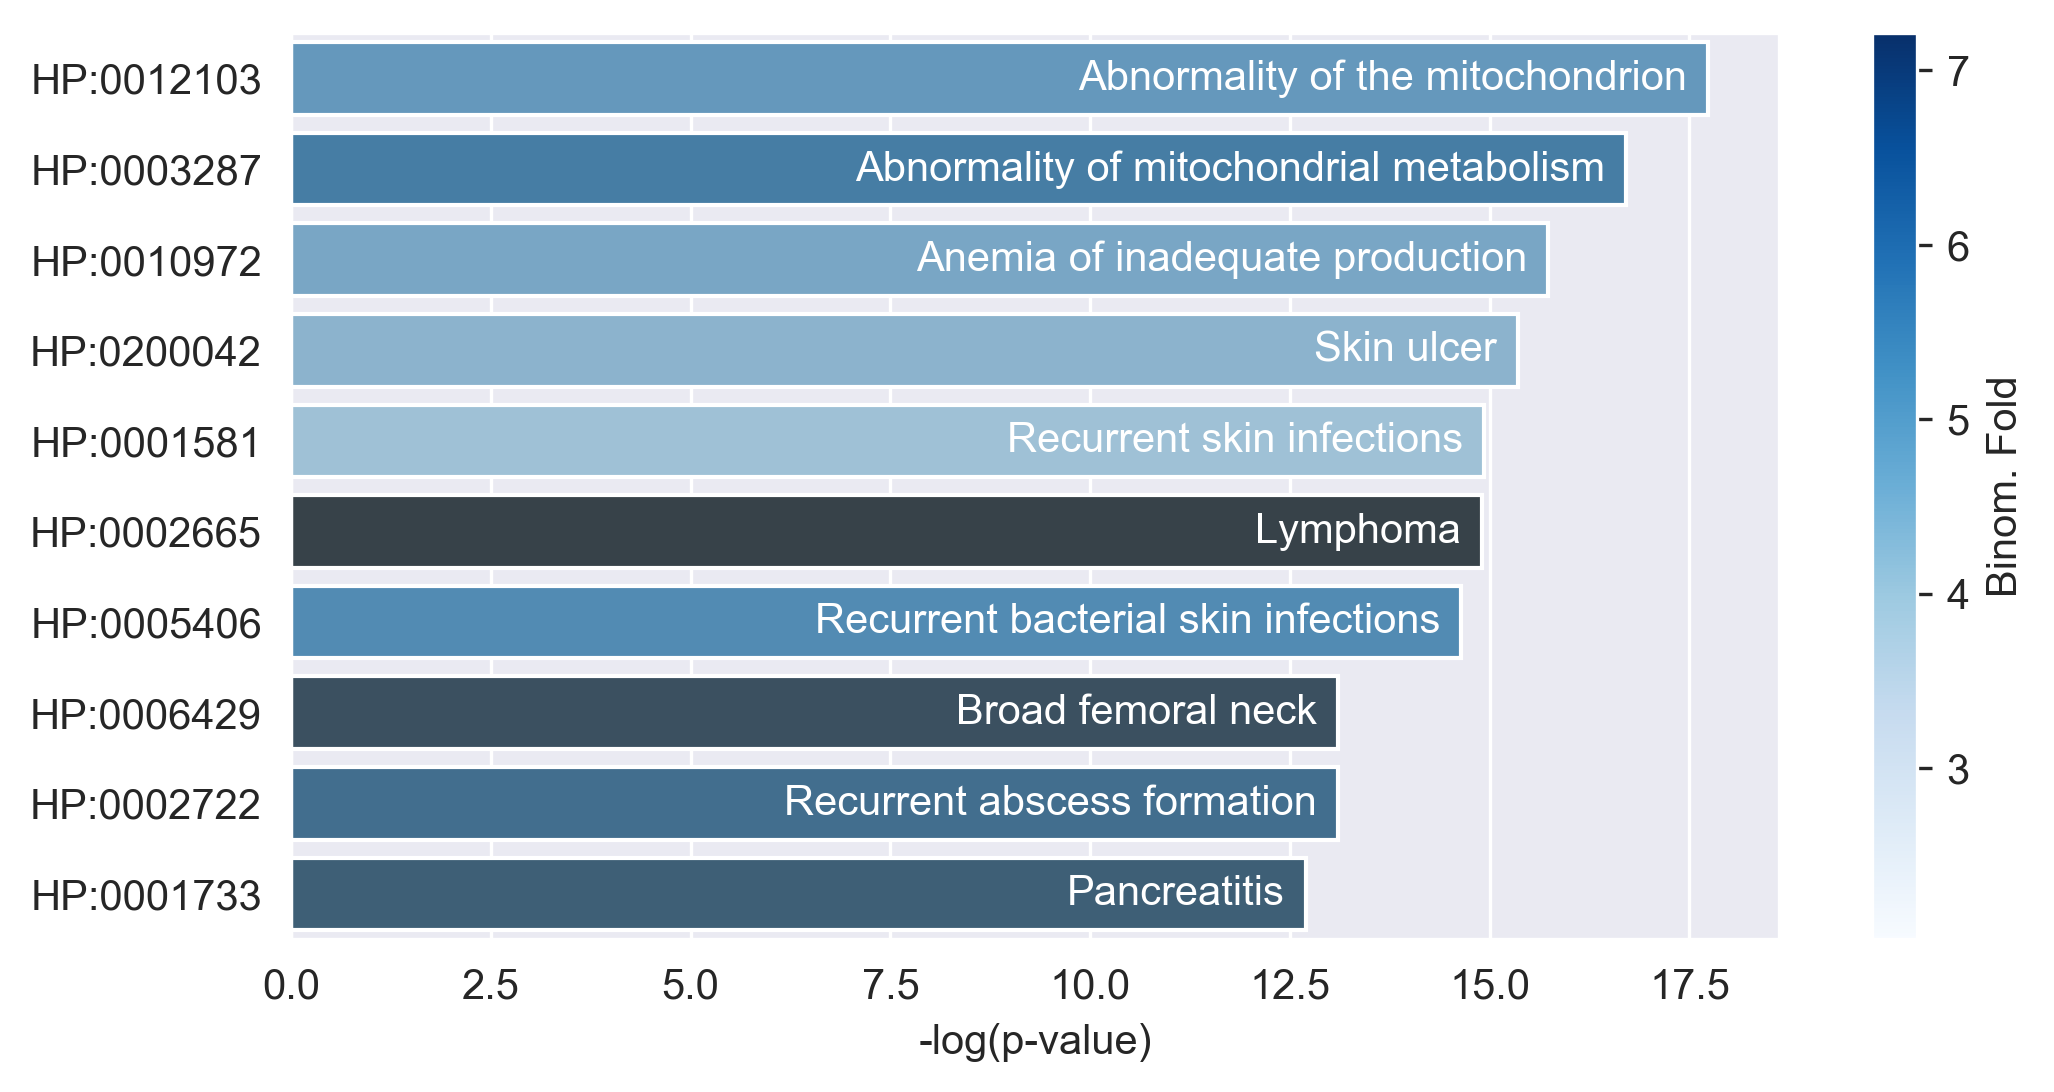

In [387]:
res = get_enrichment(get_top_pcs(phenotypes_of_interest[1])[0][0])
plot_enrichment_fig(res)

Phenotype:  Autism spectrum disorder or schizophrenia
Top PCs:  [ 1  0 37  5  2]


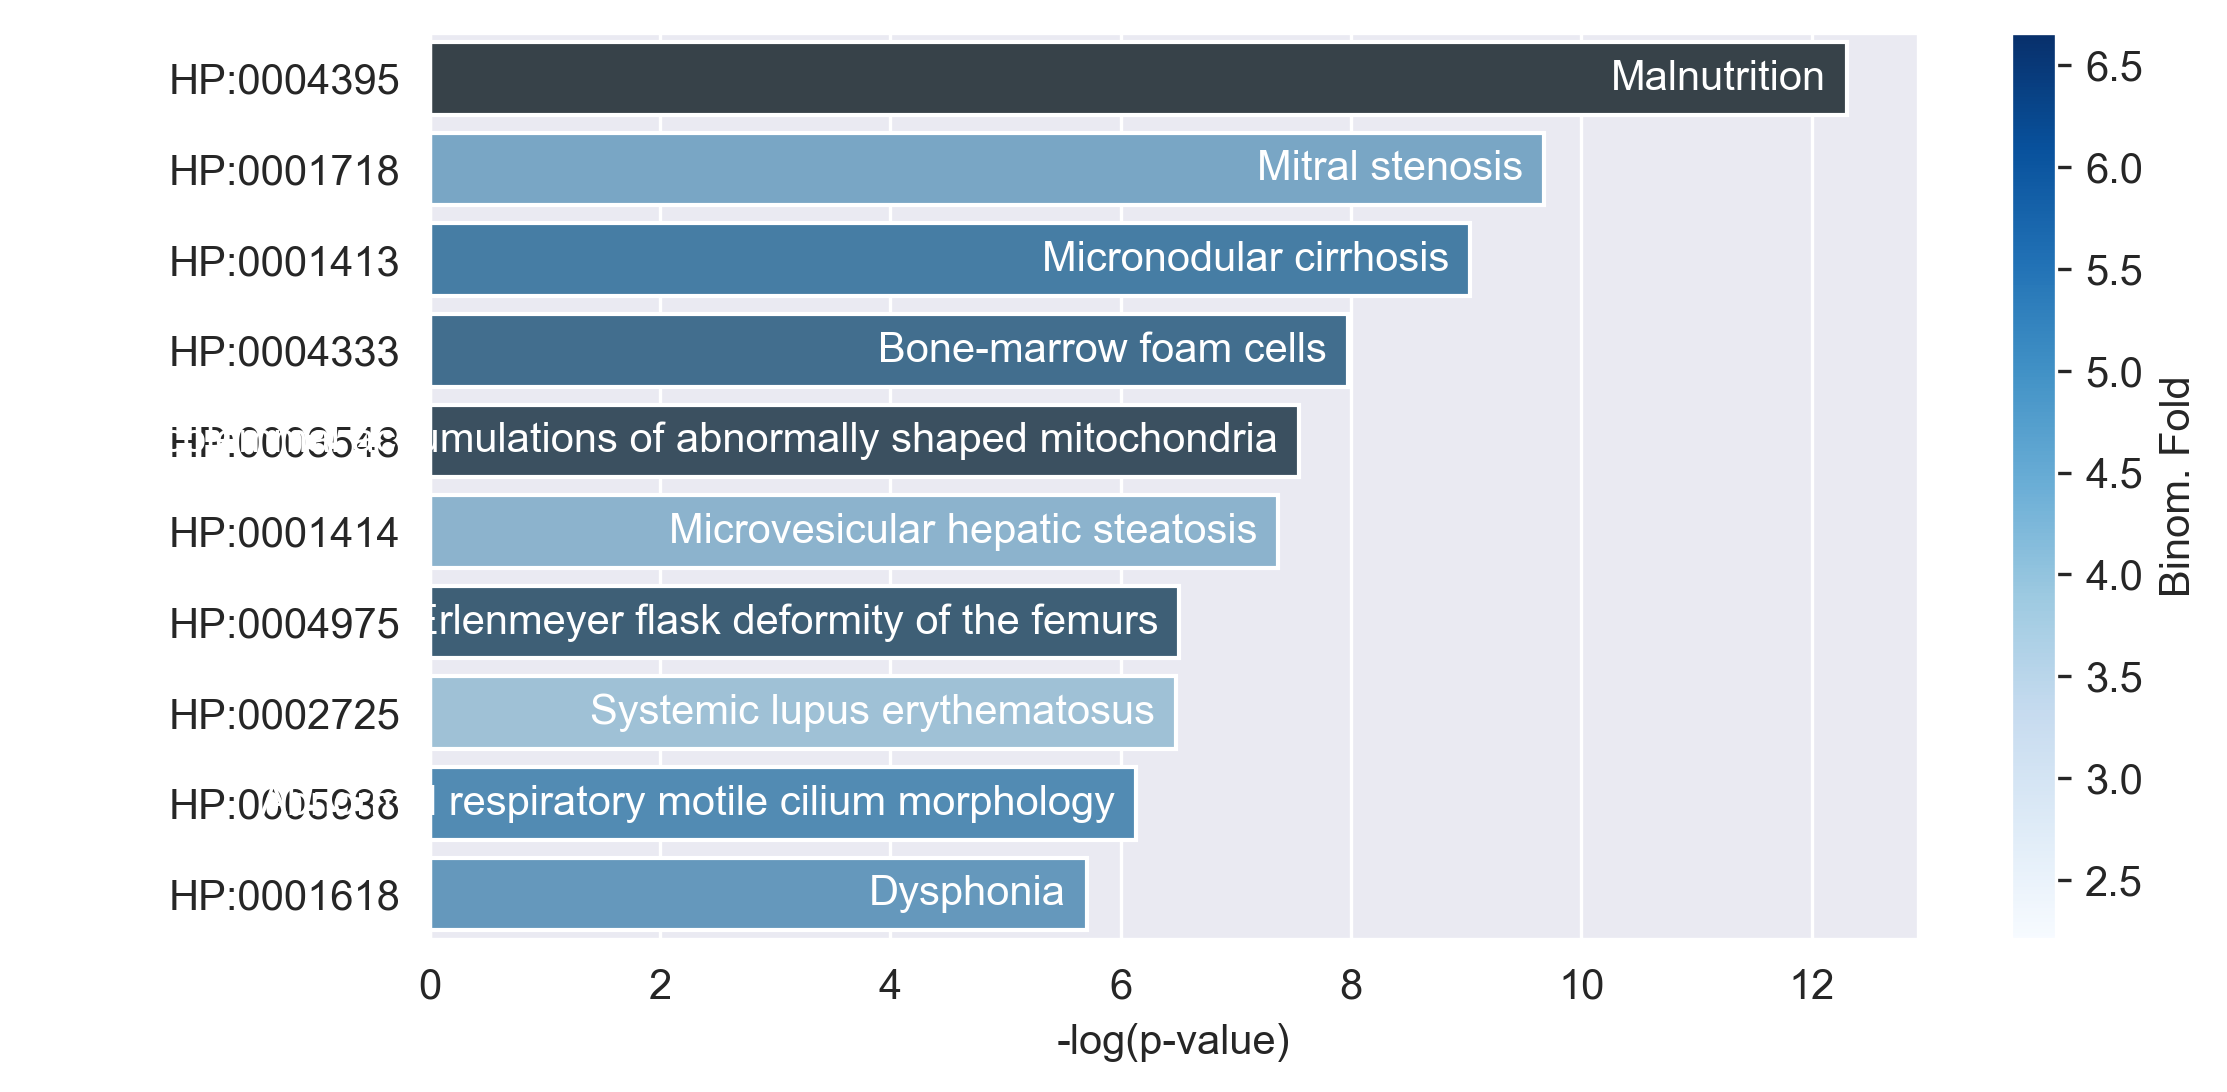

In [389]:
res = get_enrichment(get_top_pcs(phenotypes_of_interest[2])[0][0])
plot_enrichment_fig(res)

Phenotype:  Monocyte count
Top PCs:  [0 1 3 2 7]


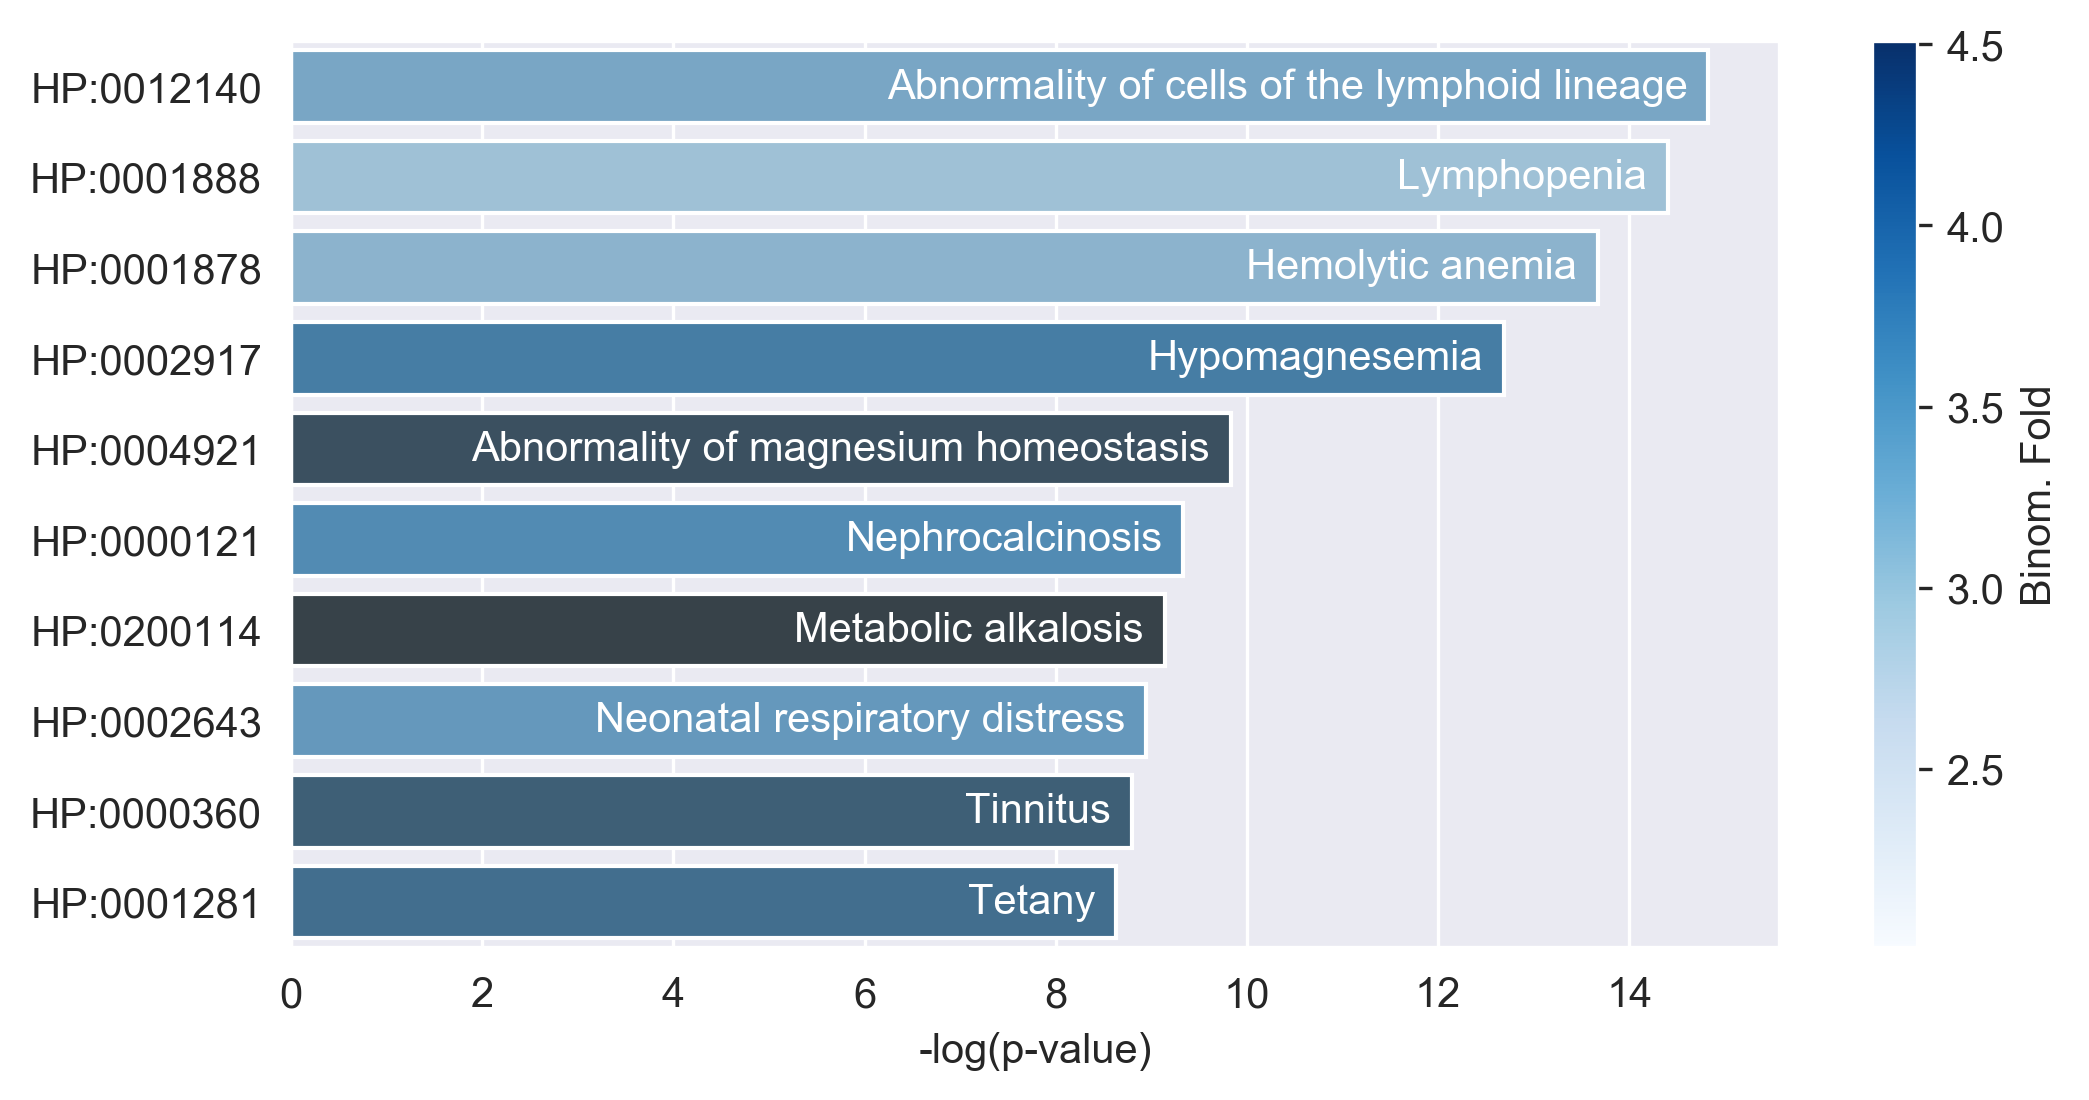

In [390]:
res = get_enrichment(get_top_pcs(phenotypes_of_interest[3])[0][0])
plot_enrichment_fig(res)

Phenotype:  IgG glycosylation
Top PCs:  [ 2  0  5  1 27]


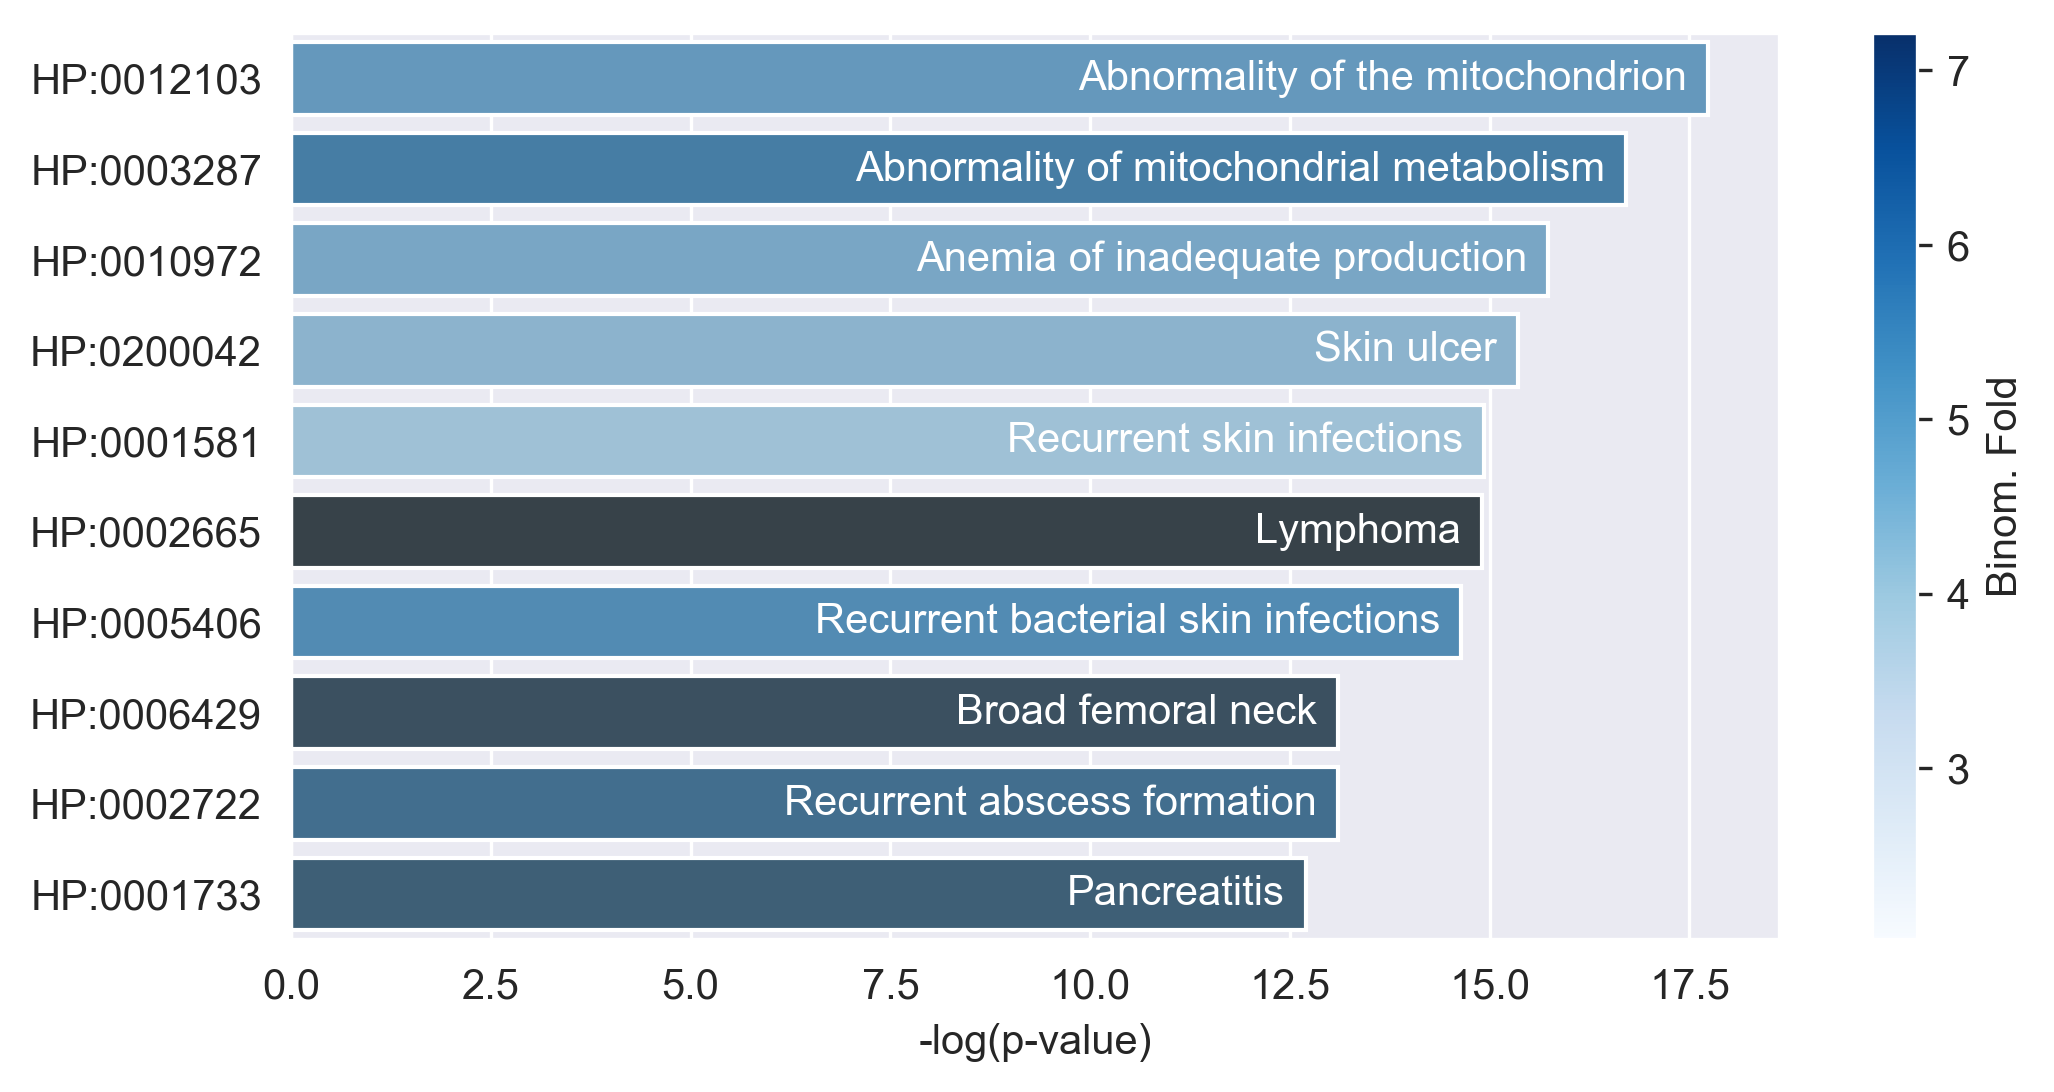

In [391]:
res = get_enrichment(get_top_pcs(phenotypes_of_interest[4])[0][0])
plot_enrichment_fig(res)

Phenotype:  Reticulocyte count
Top PCs:  [0 1 3 2 5]


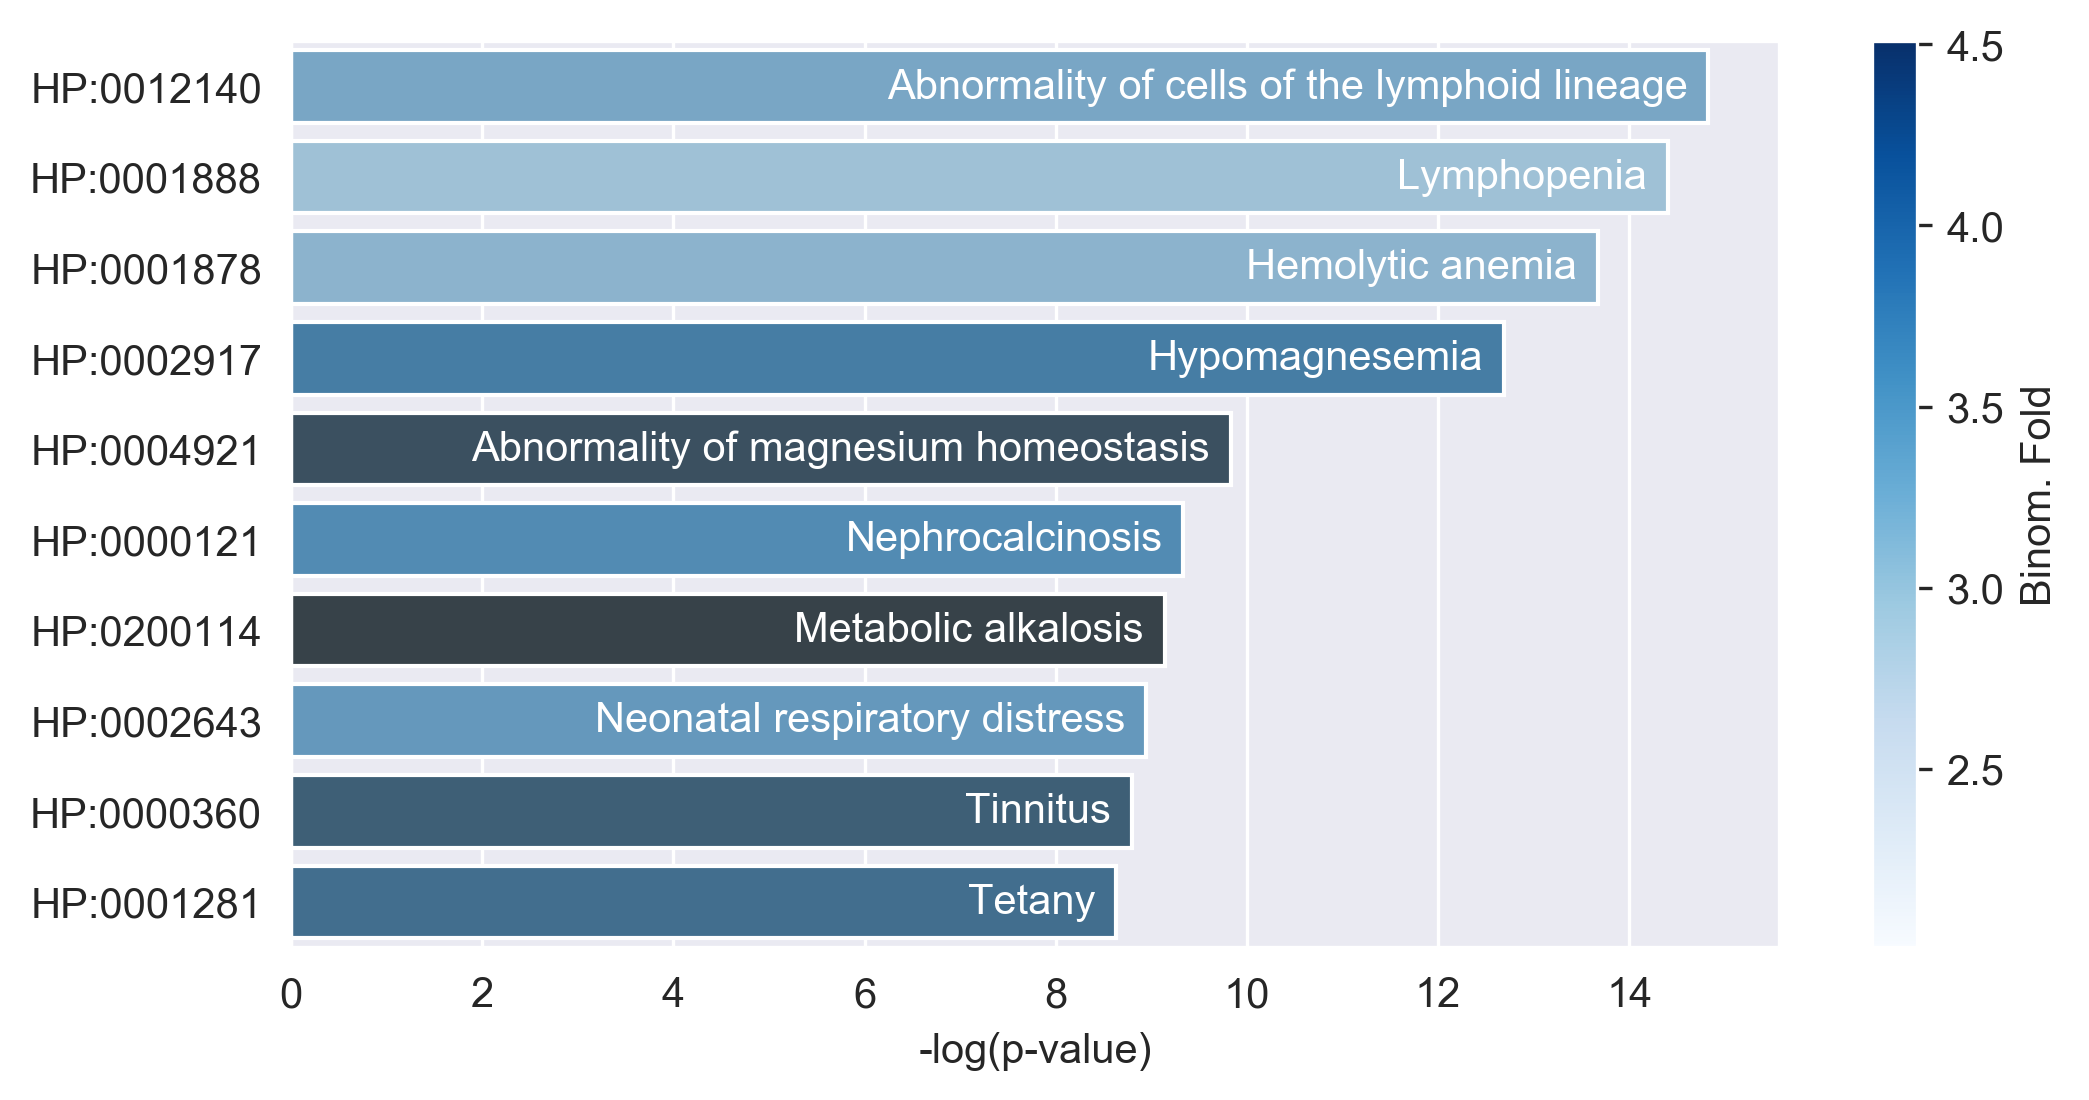

In [392]:
res = get_enrichment(get_top_pcs(phenotypes_of_interest[5])[0][0])
plot_enrichment_fig(res)

Phenotype:  Psoriasis
Top PCs:  [ 1  2 37 94  5]


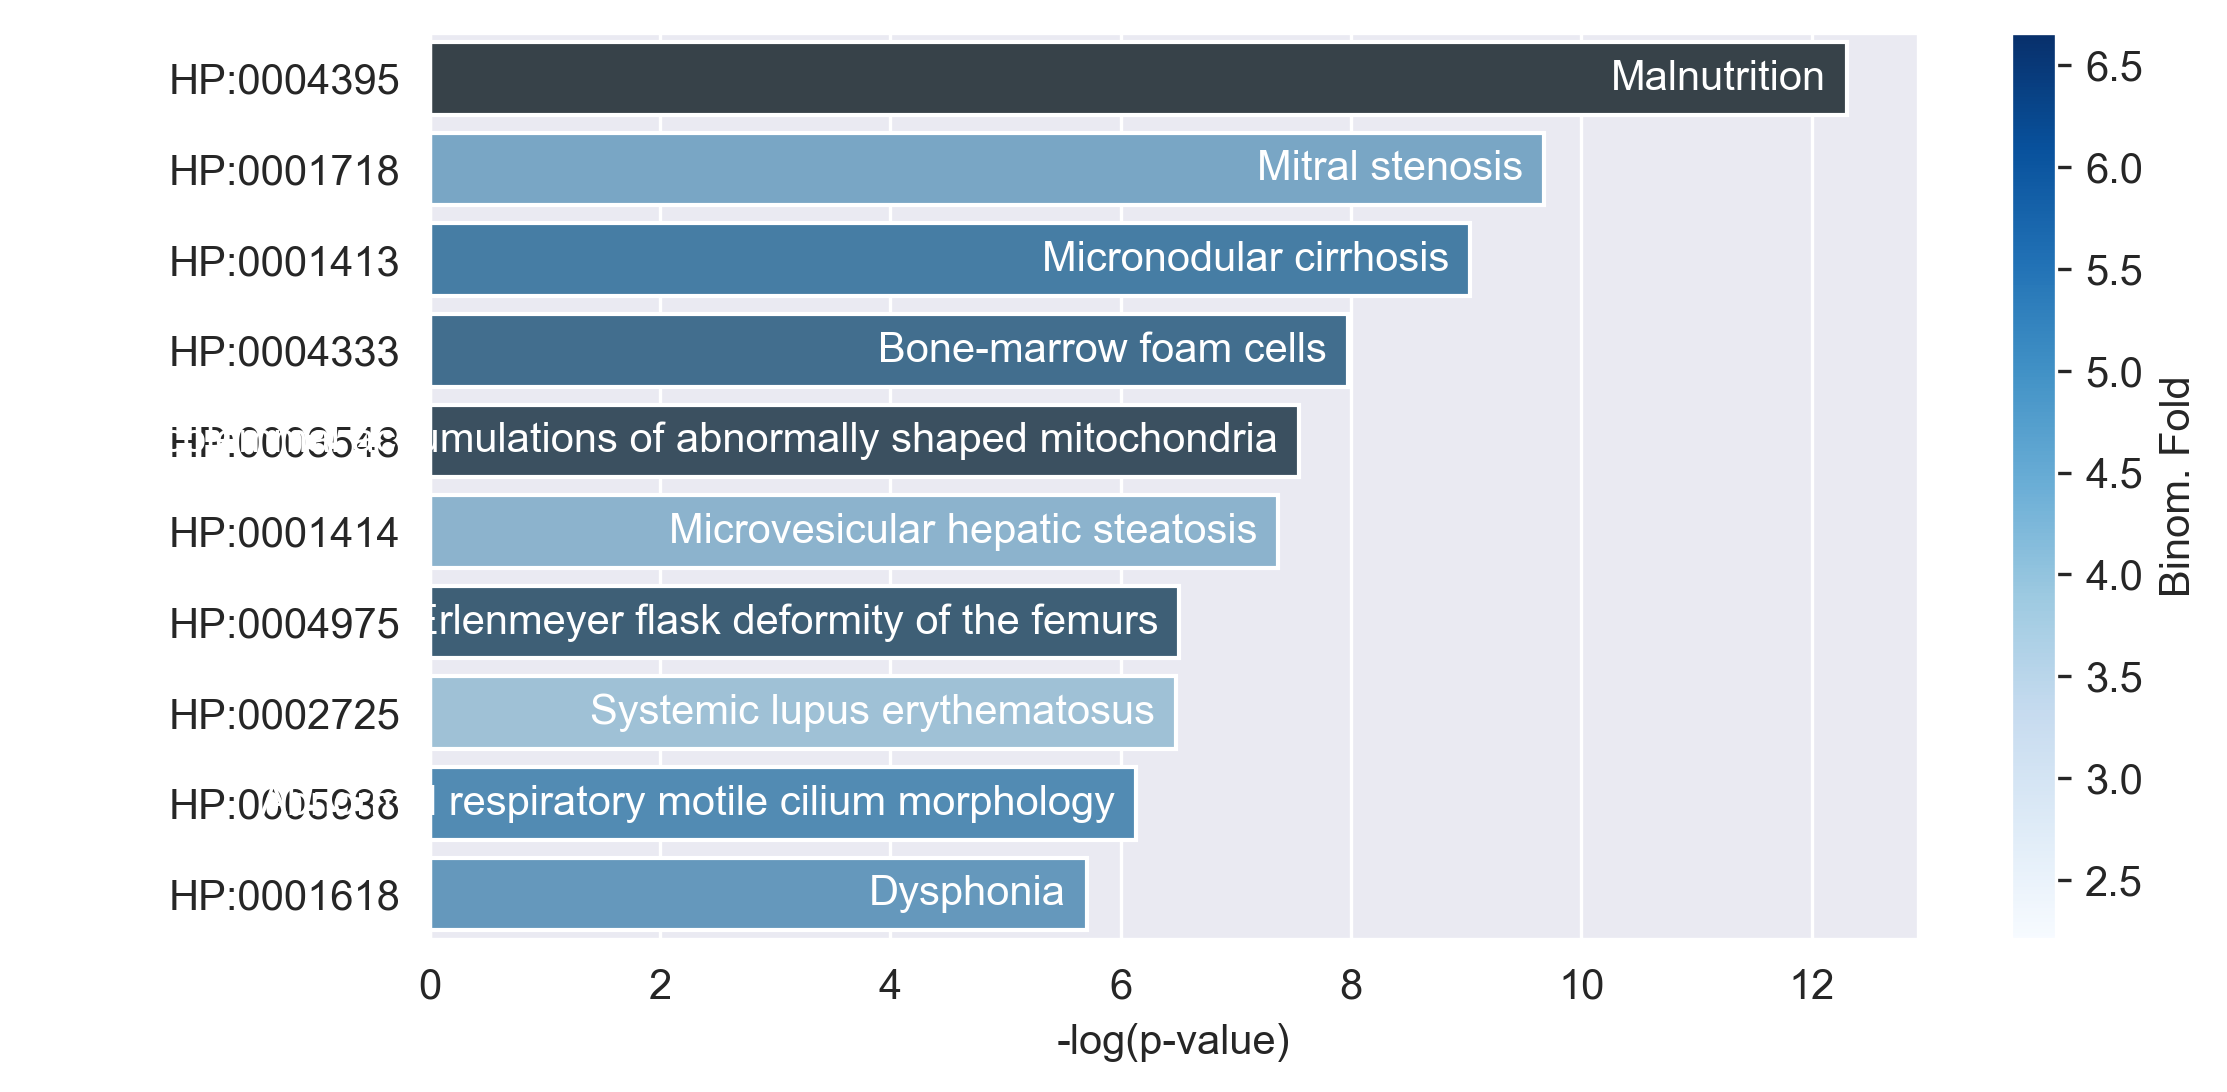

In [393]:
res = get_enrichment(get_top_pcs(phenotypes_of_interest[6])[0][0])
plot_enrichment_fig(res)

Phenotype:  Eosinophil percentage of granulocytes
Top PCs:  [0 1 3 2 9]


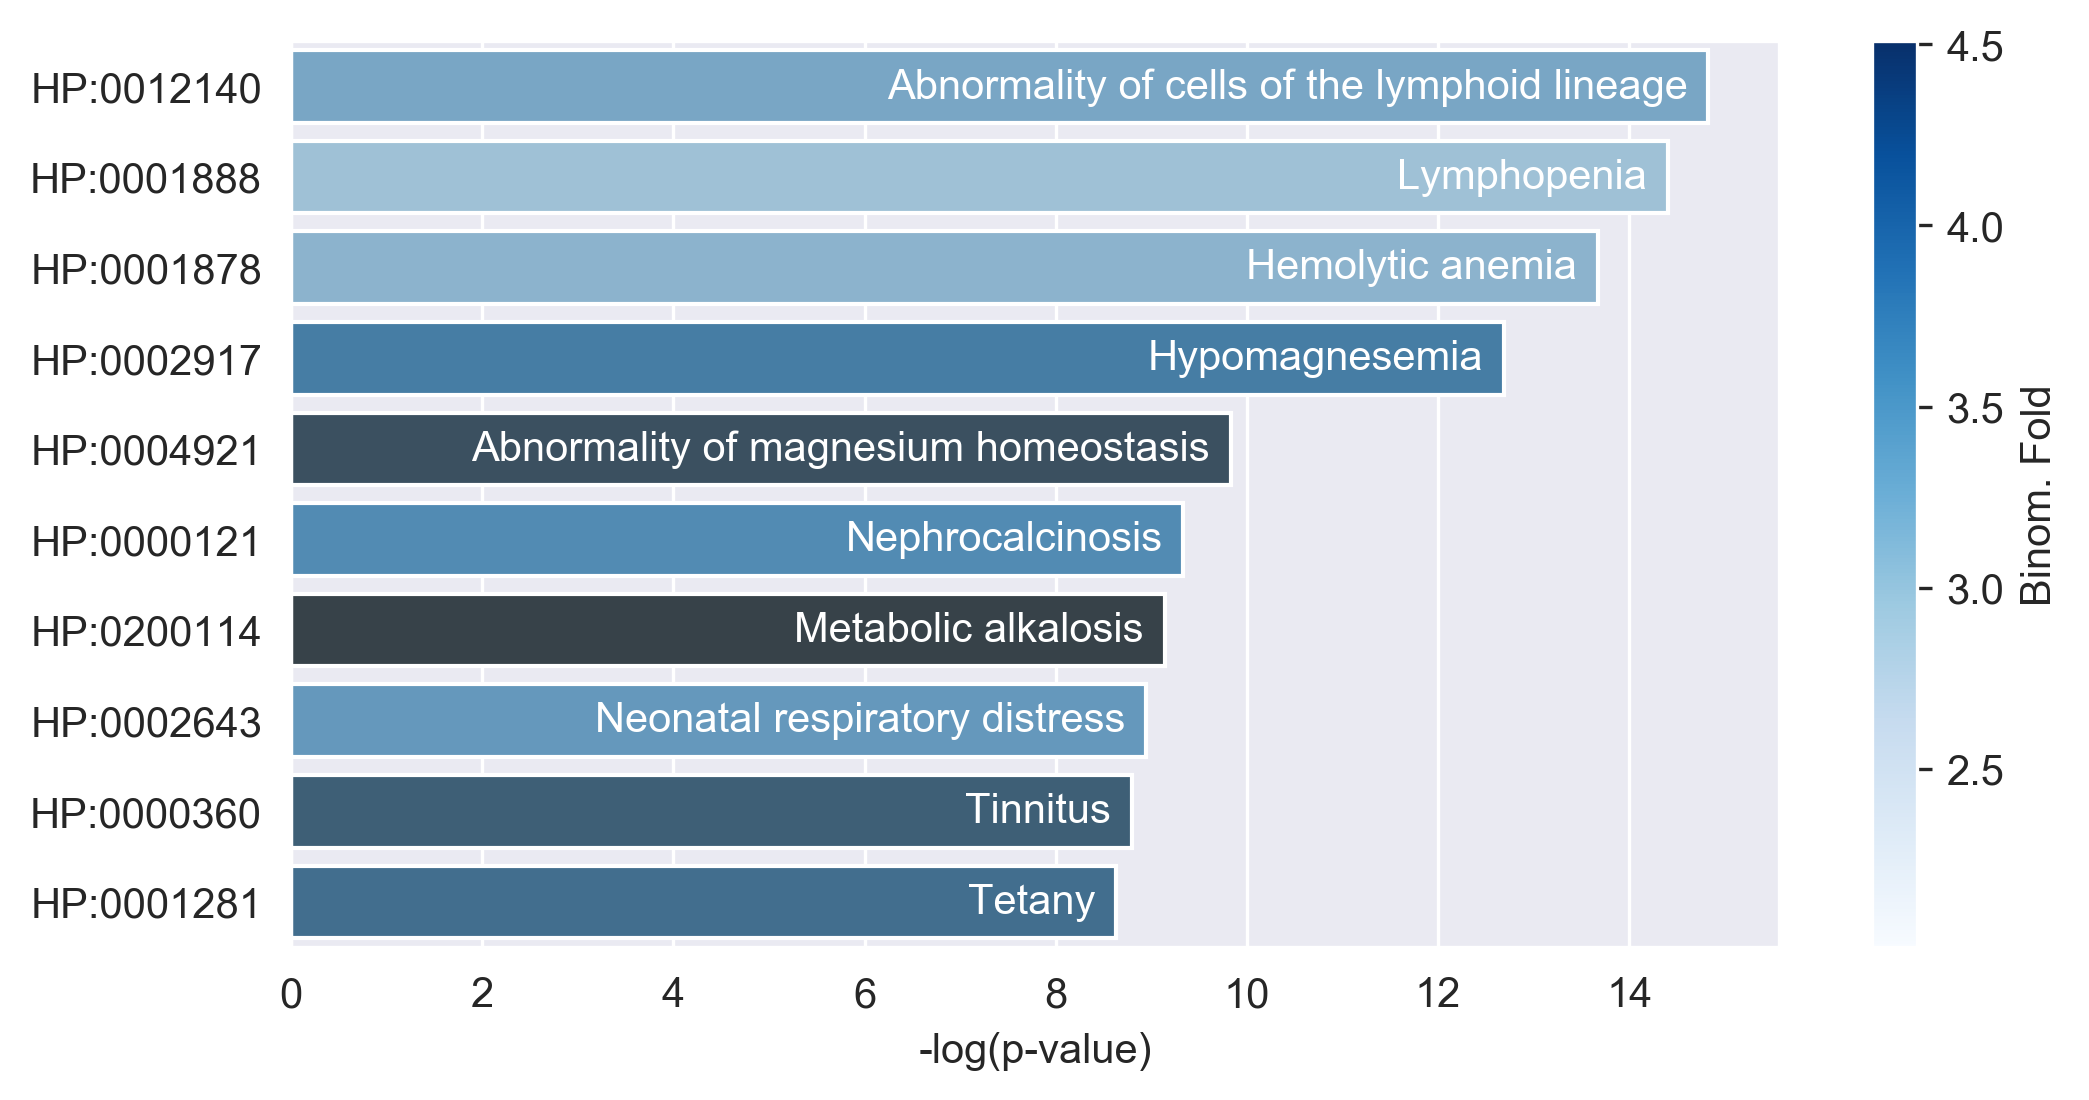

In [394]:
res = get_enrichment(get_top_pcs(phenotypes_of_interest[7])[0][0])
plot_enrichment_fig(res)

Phenotype:  Lymphocyte percentage of white cells
Top PCs:  [2 3 1 0 5]


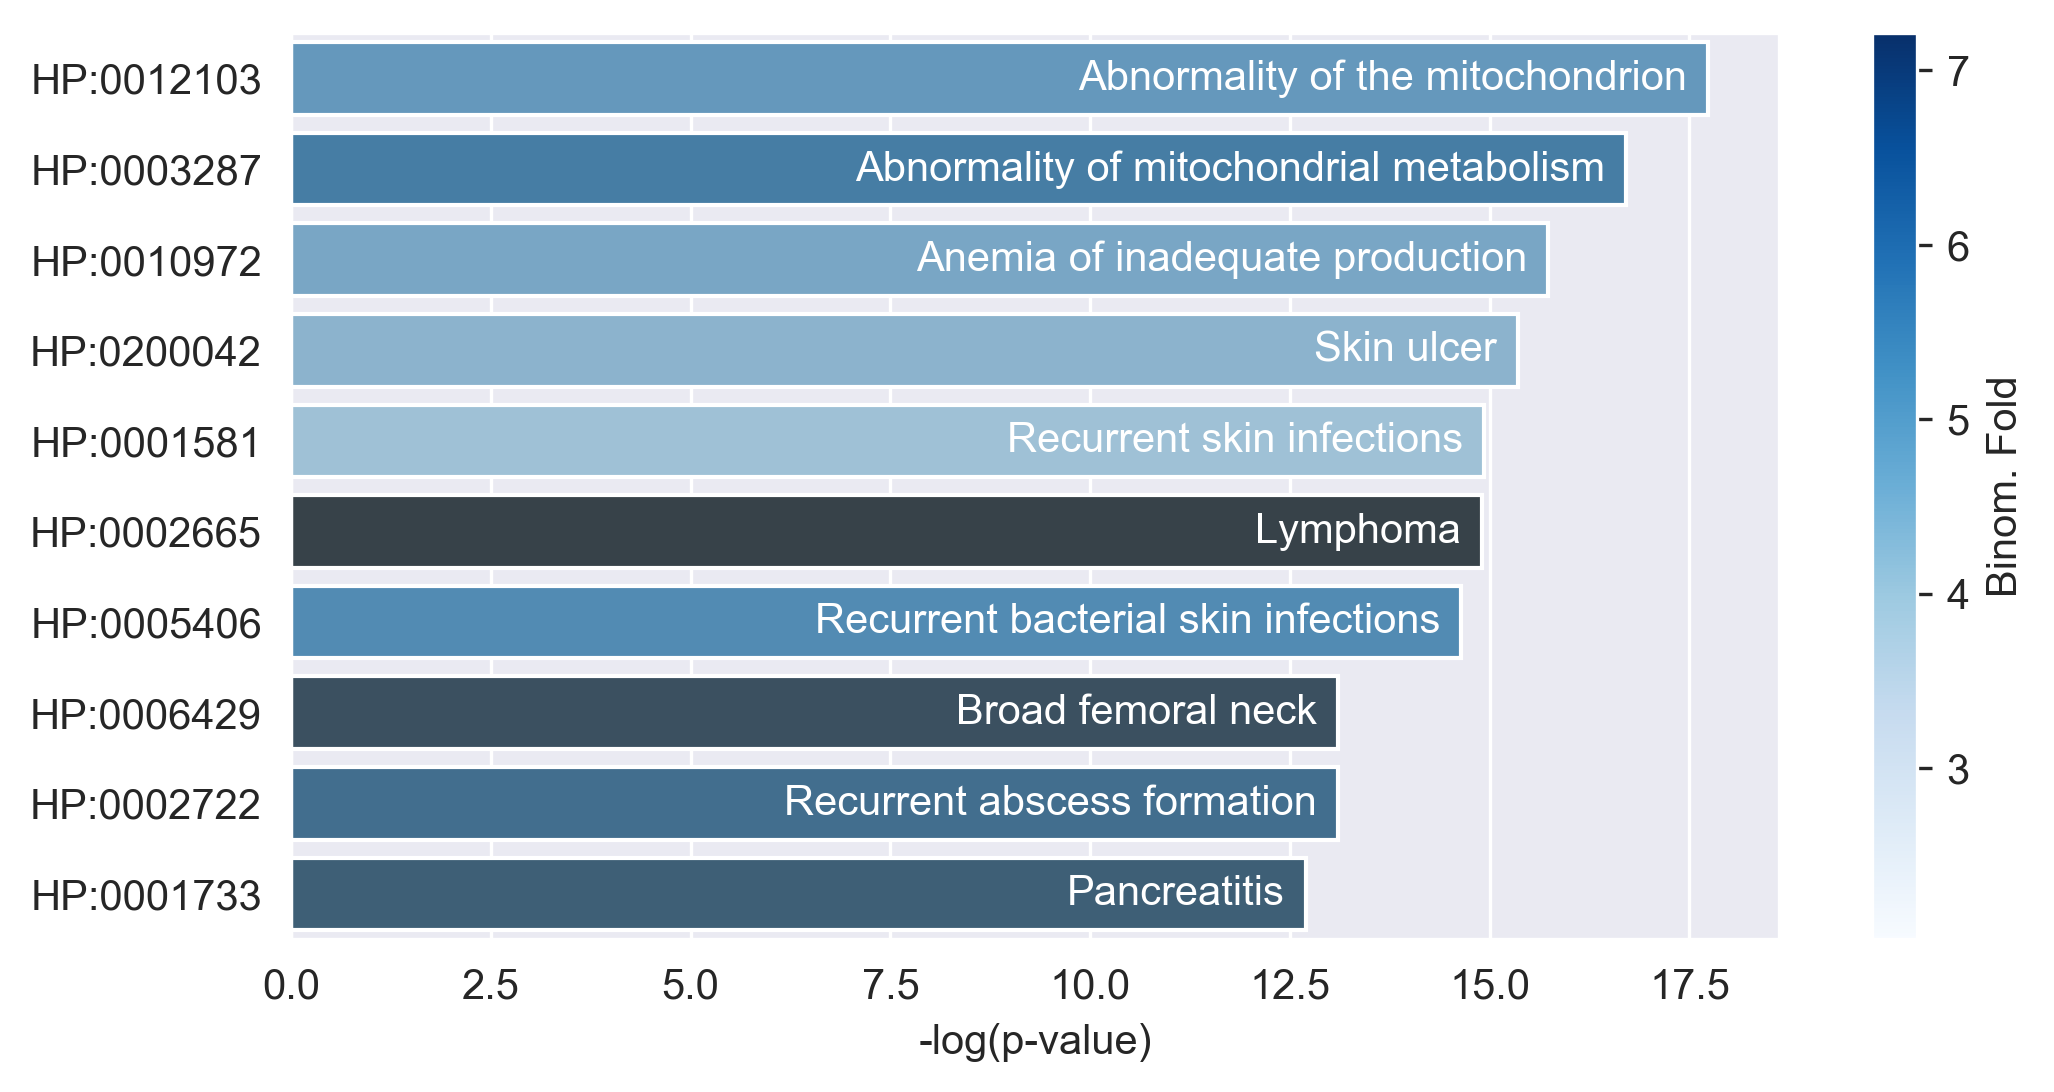

In [395]:
res = get_enrichment(get_top_pcs(phenotypes_of_interest[8])[0][0])
plot_enrichment_fig(res)

Phenotype:  Systemic lupus erythematosus
Top PCs:  [0 1 3 2 5]


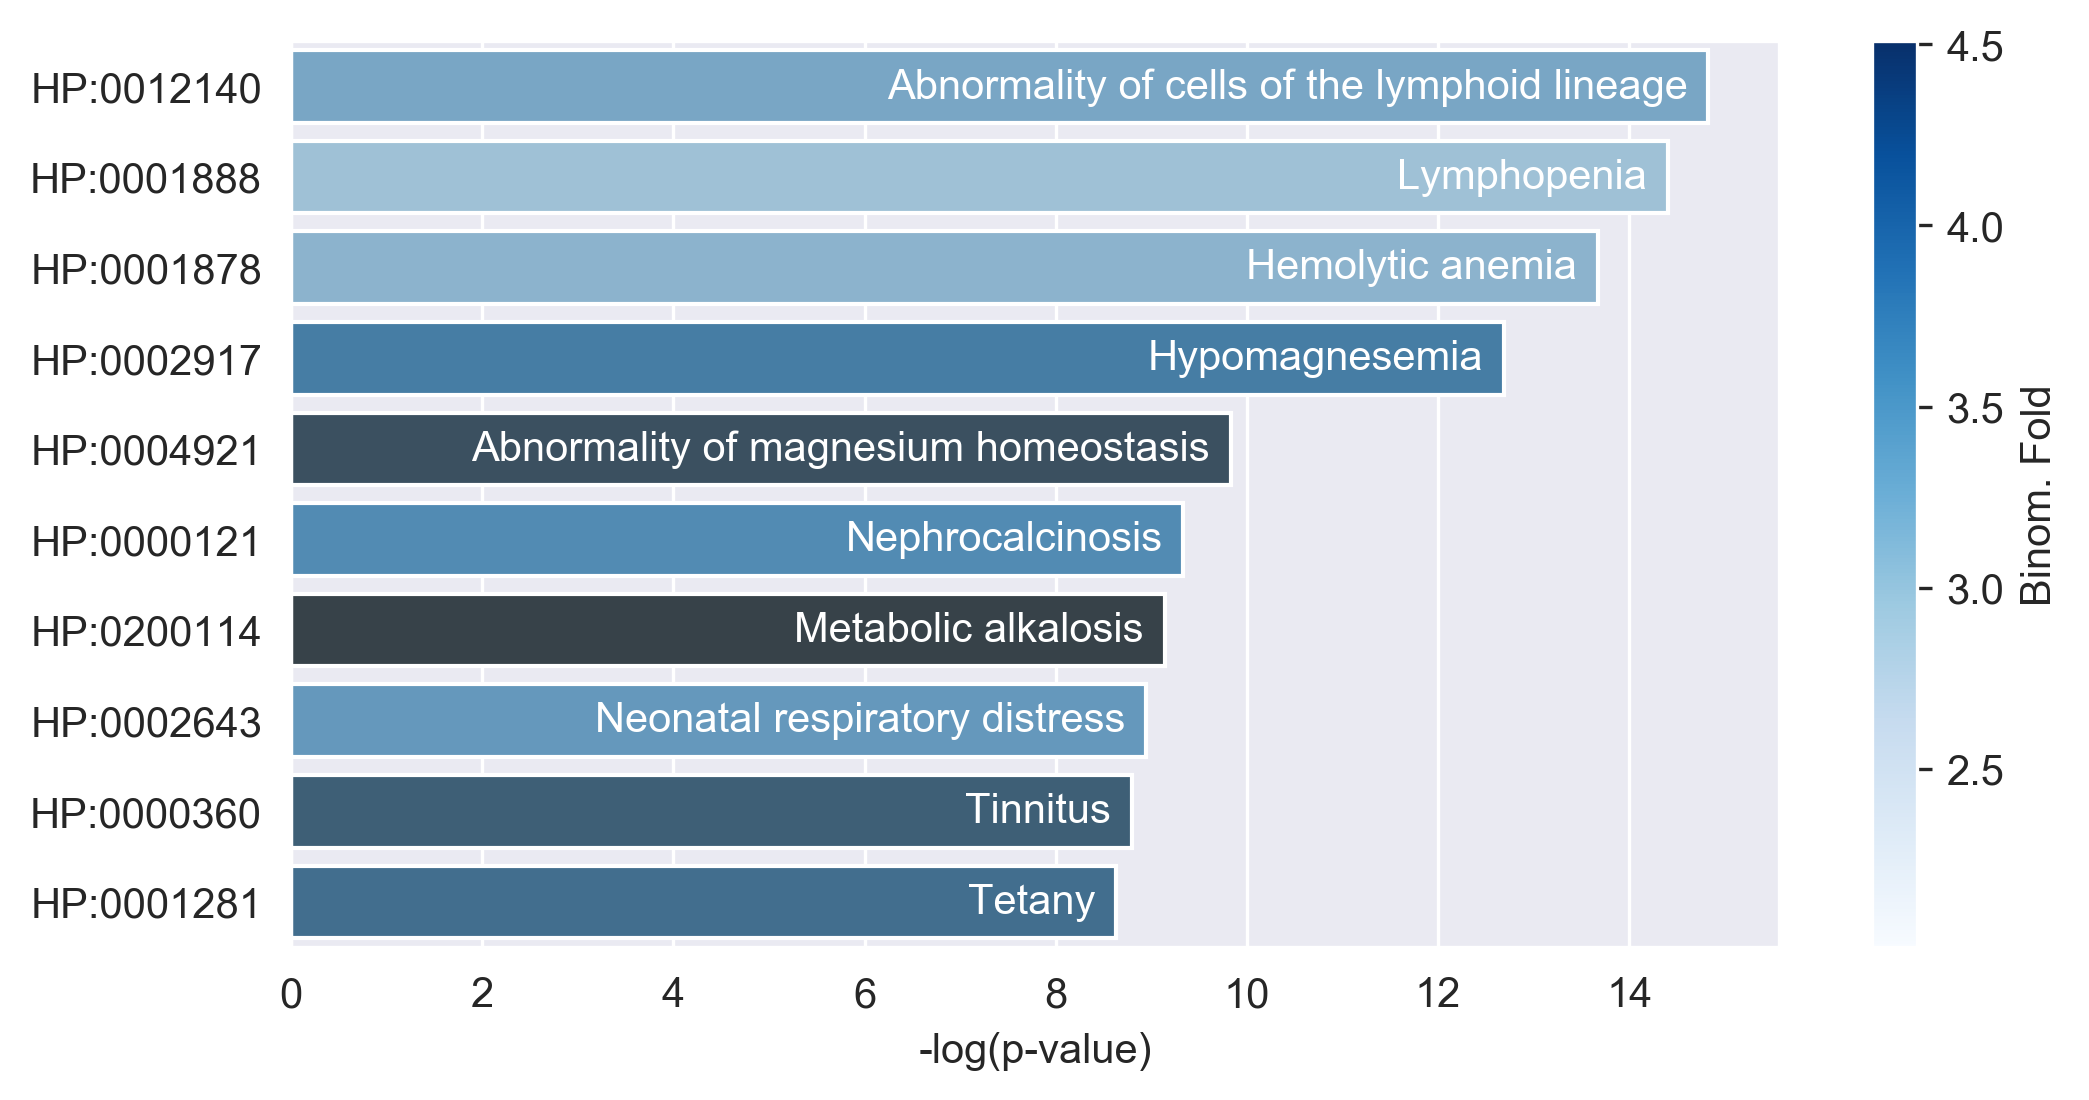

In [396]:
res = get_enrichment(get_top_pcs(phenotypes_of_interest[9])[0][0])
plot_enrichment_fig(res)

Phenotype:  Monocyte percentage of white cells
Top PCs:  [ 1  0  3 17  5]


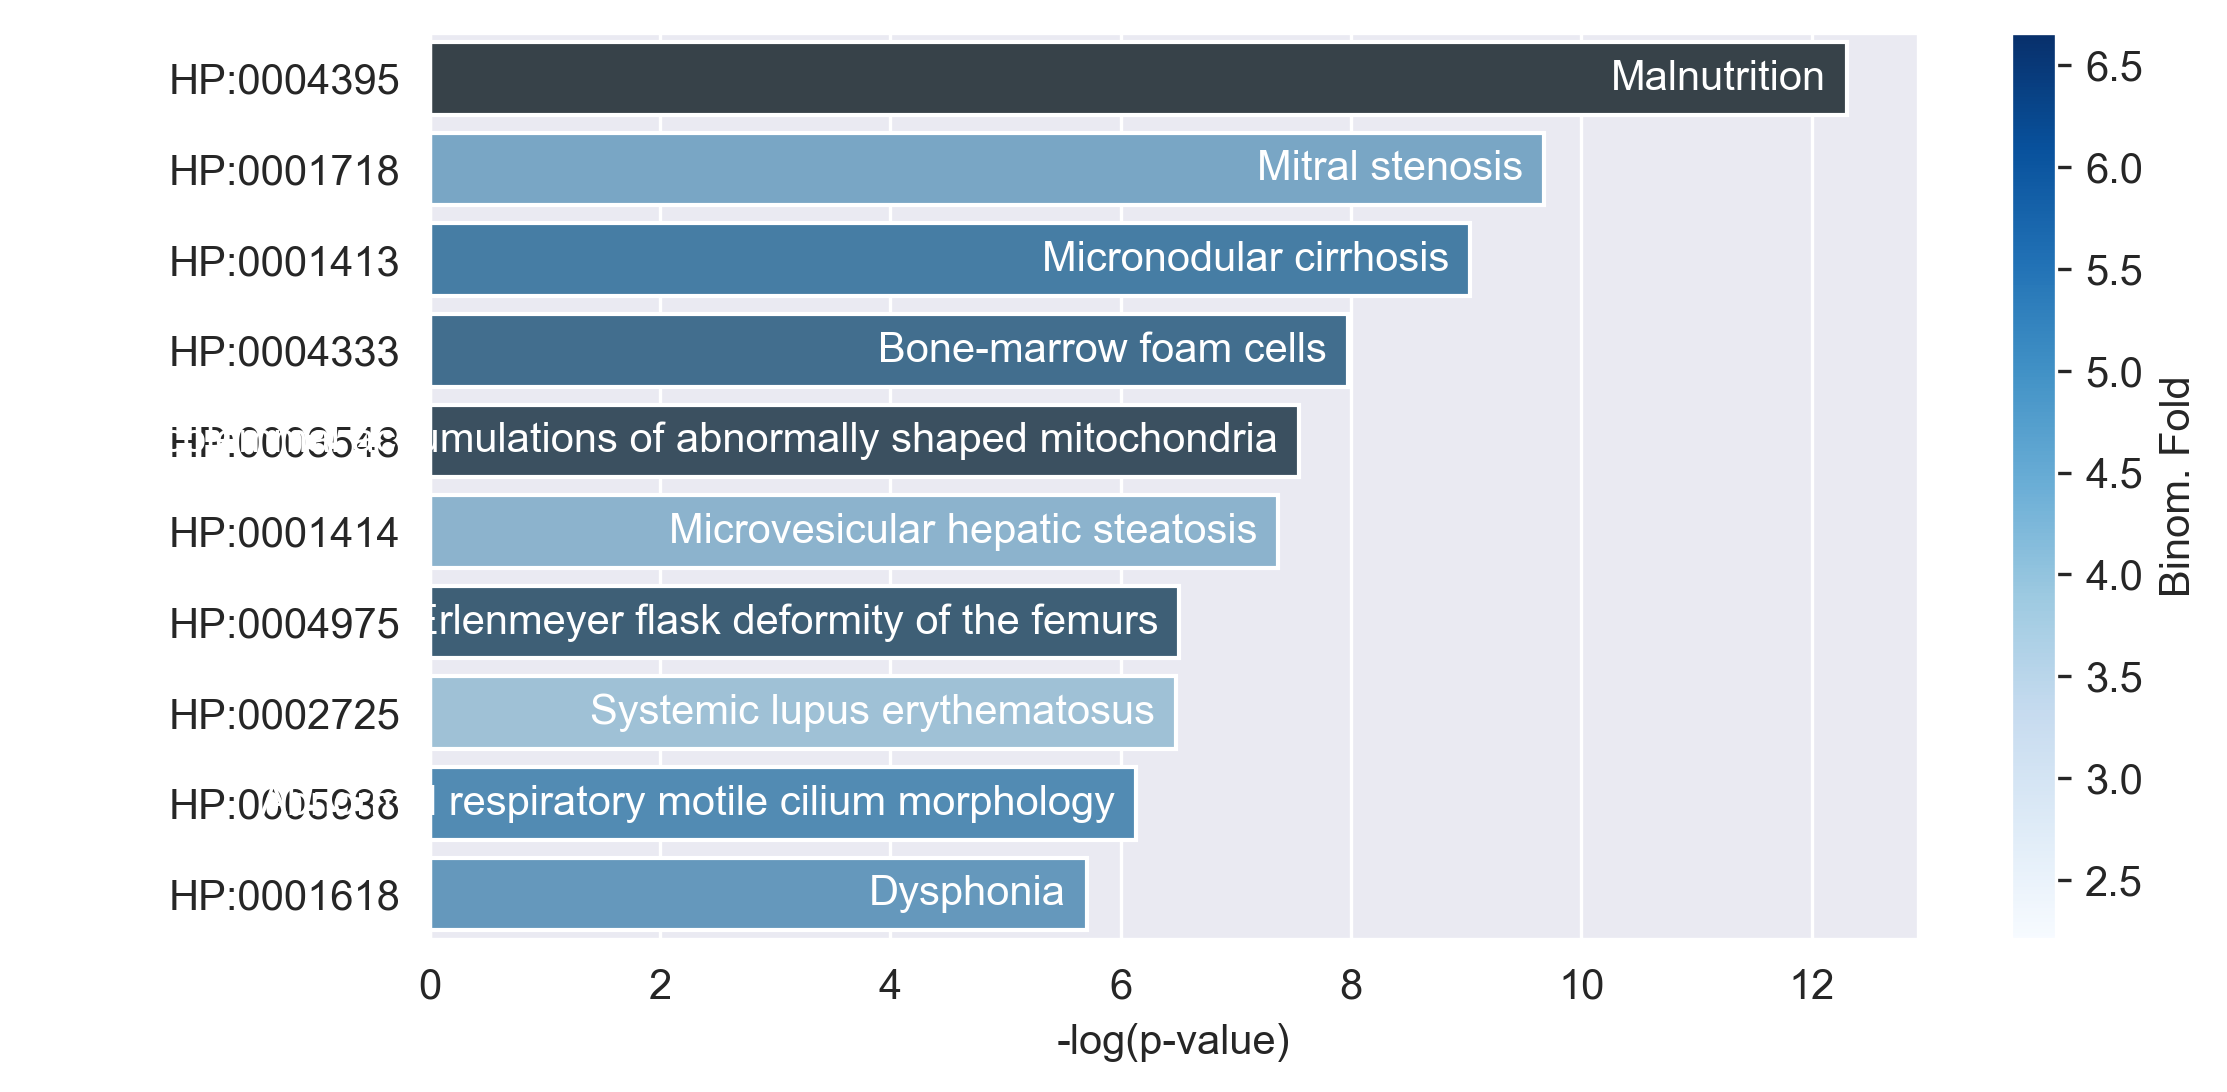

In [397]:
res = get_enrichment(get_top_pcs(phenotypes_of_interest[10])[0][0])
plot_enrichment_fig(res)

Phenotype:  Reticulocyte fraction of red cells
Top PCs:  [0 3 1 2 5]


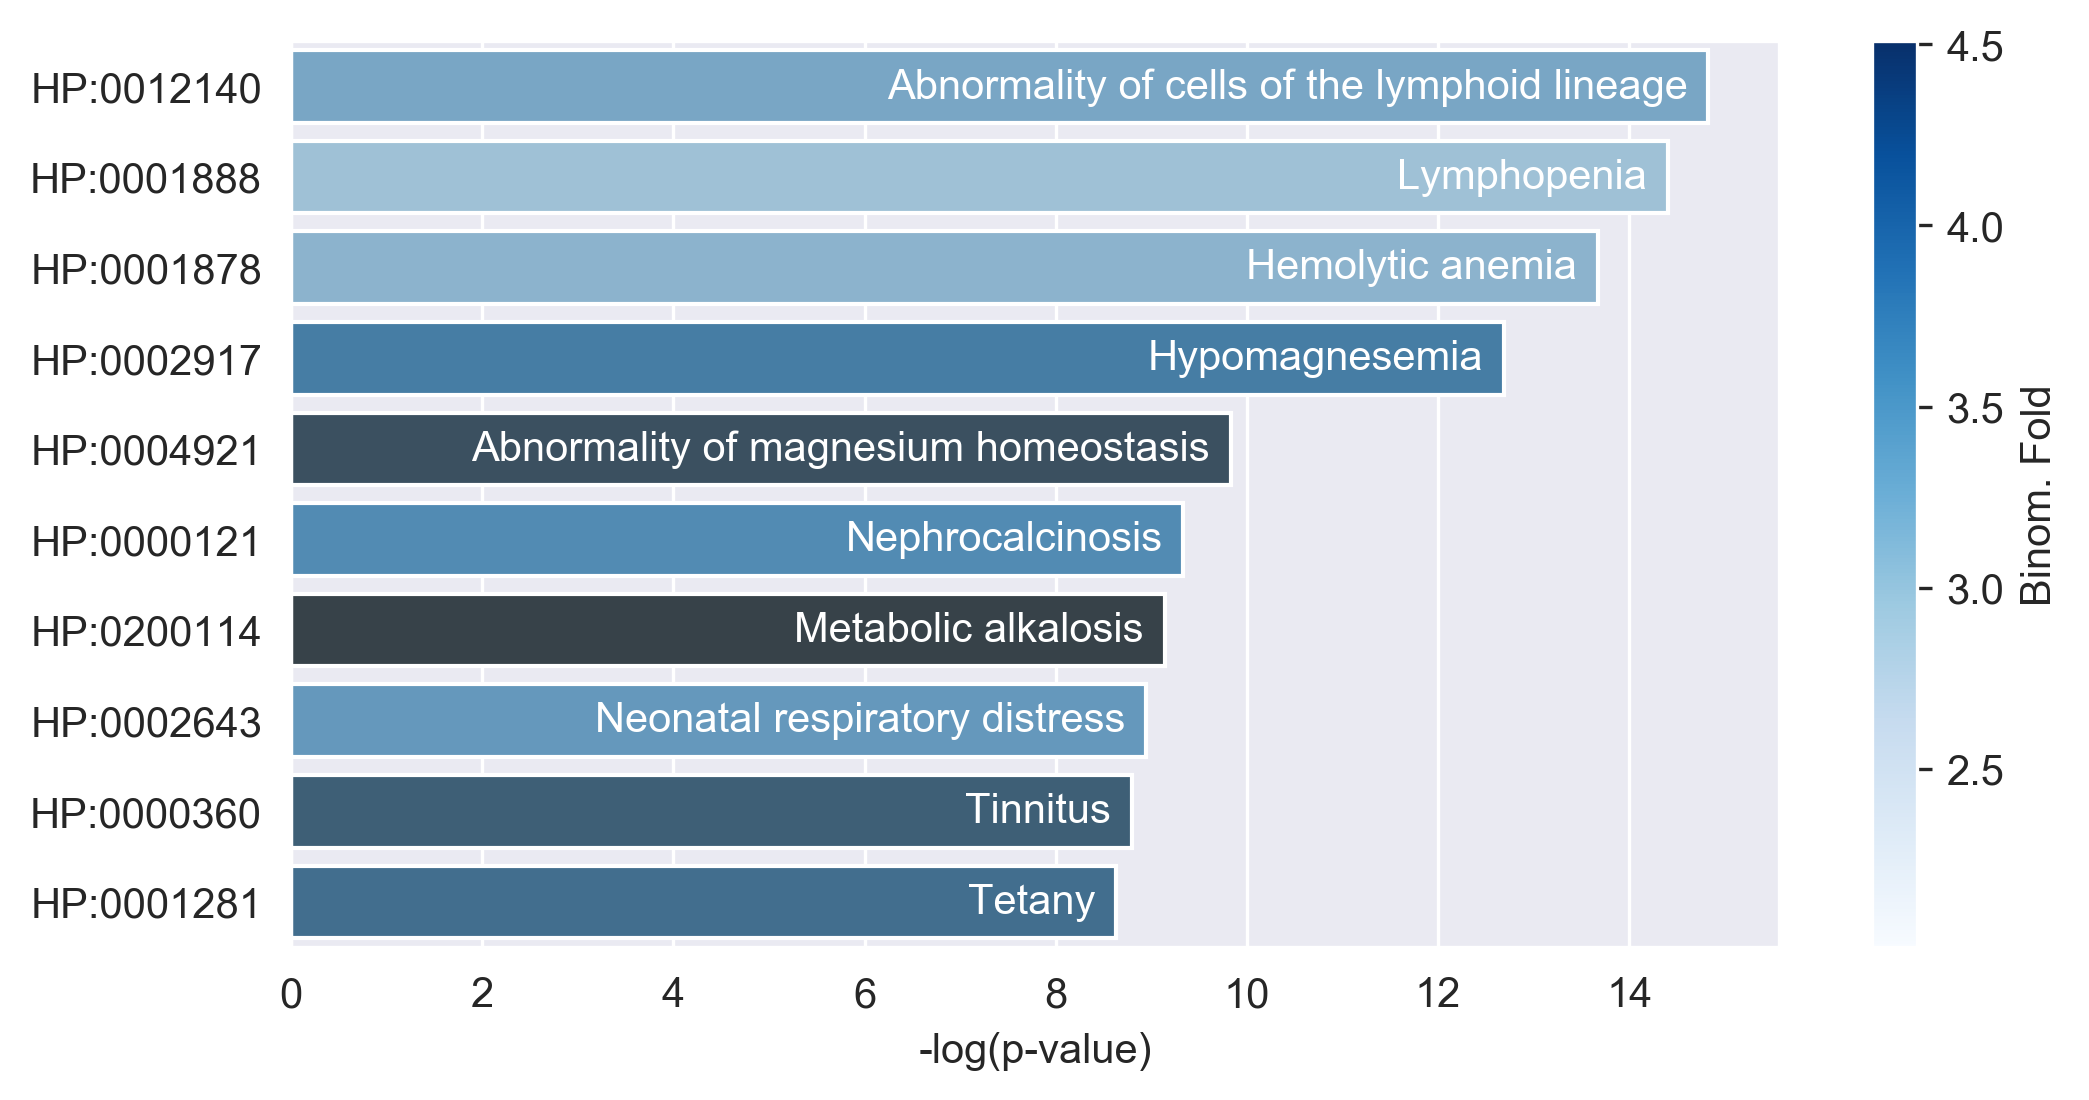

In [398]:
res = get_enrichment(get_top_pcs(phenotypes_of_interest[11])[0][0])
plot_enrichment_fig(res)

Phenotype:  Eosinophil percentage of white cells
Top PCs:  [1 0 3 2 5]


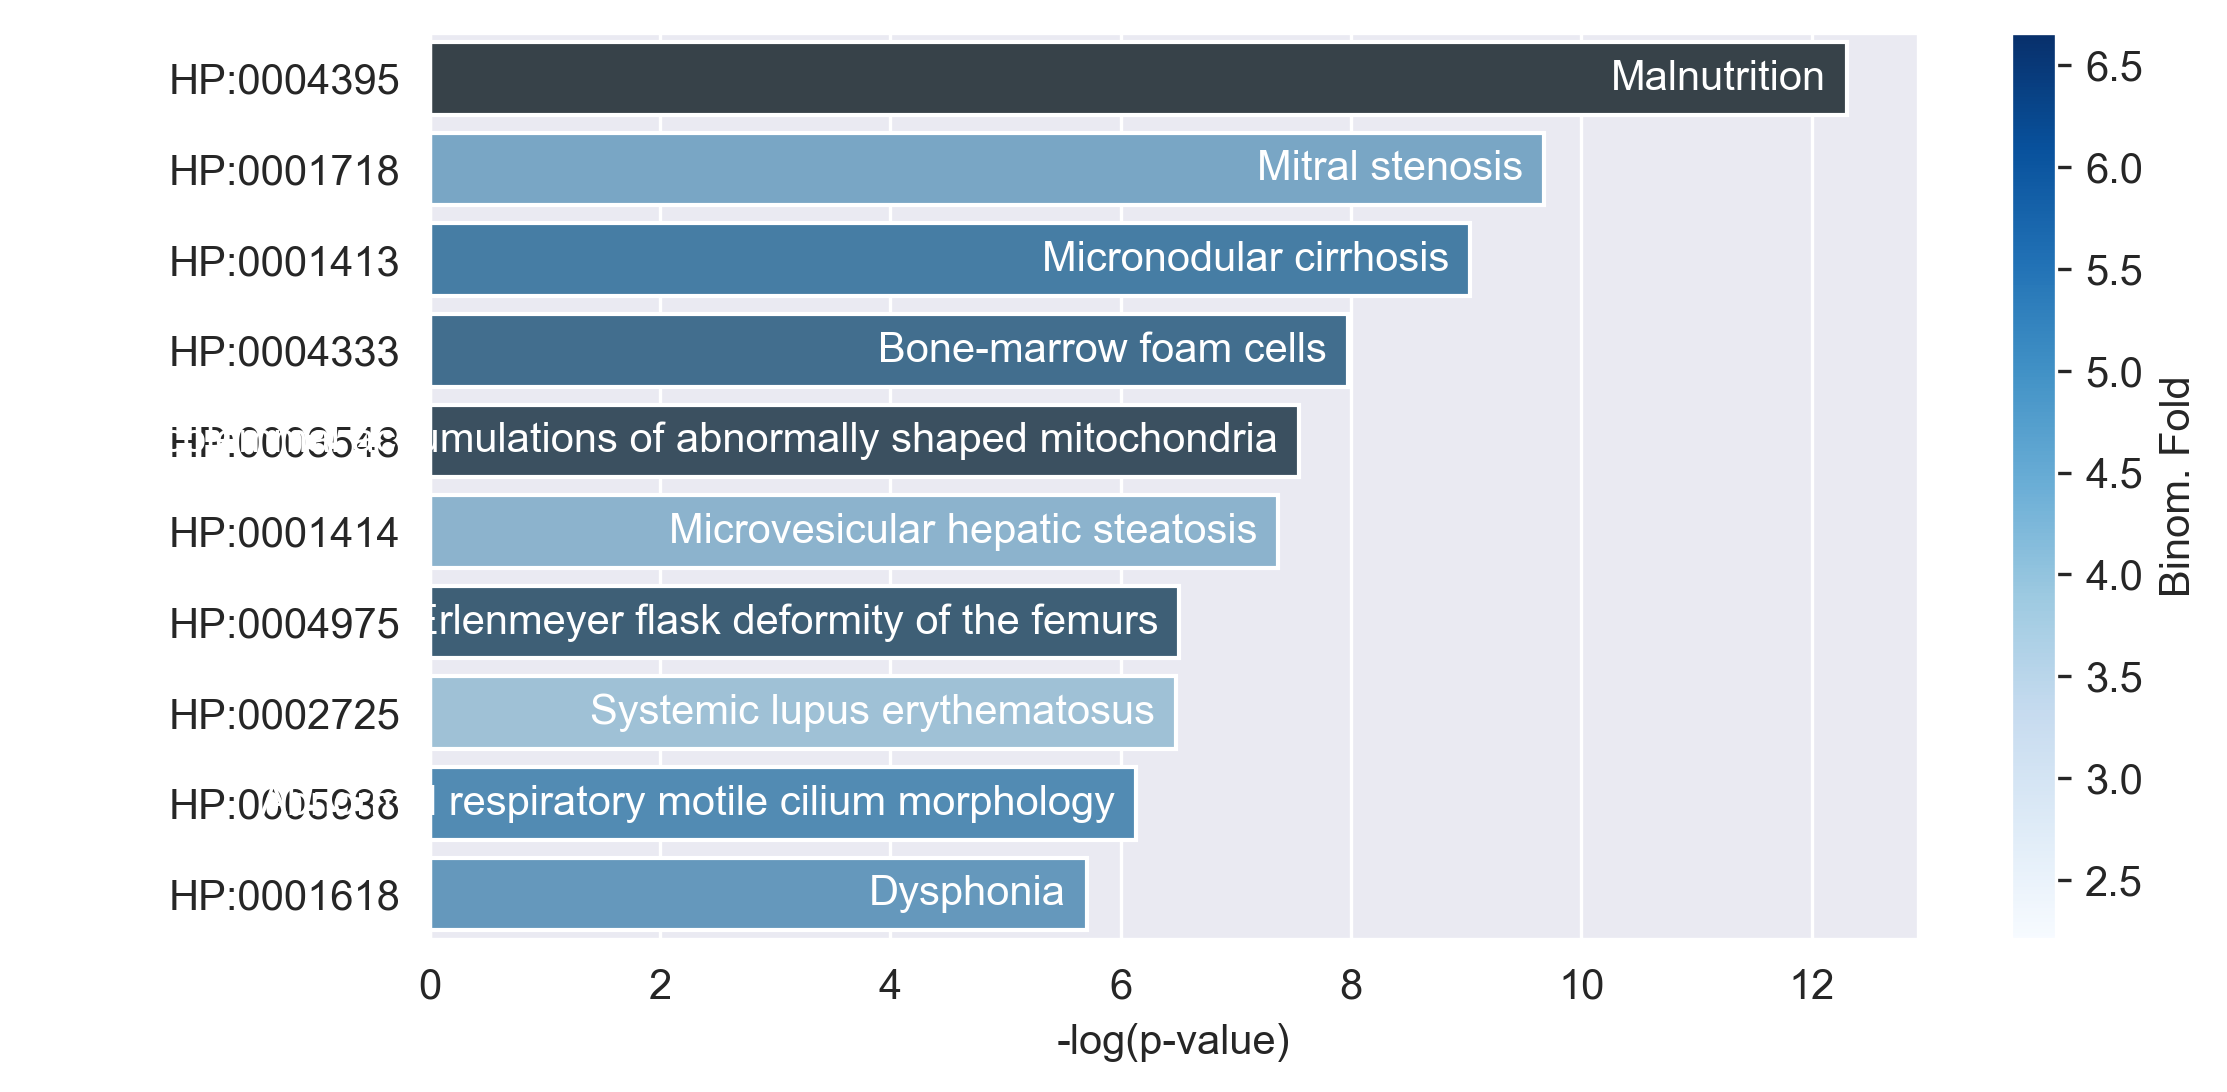

In [399]:
res = get_enrichment(get_top_pcs(phenotypes_of_interest[12])[0][0])
plot_enrichment_fig(res)

Phenotype:  Granulocyte percentage of myeloid white cells
Top PCs:  [ 0  3  1 14  2]


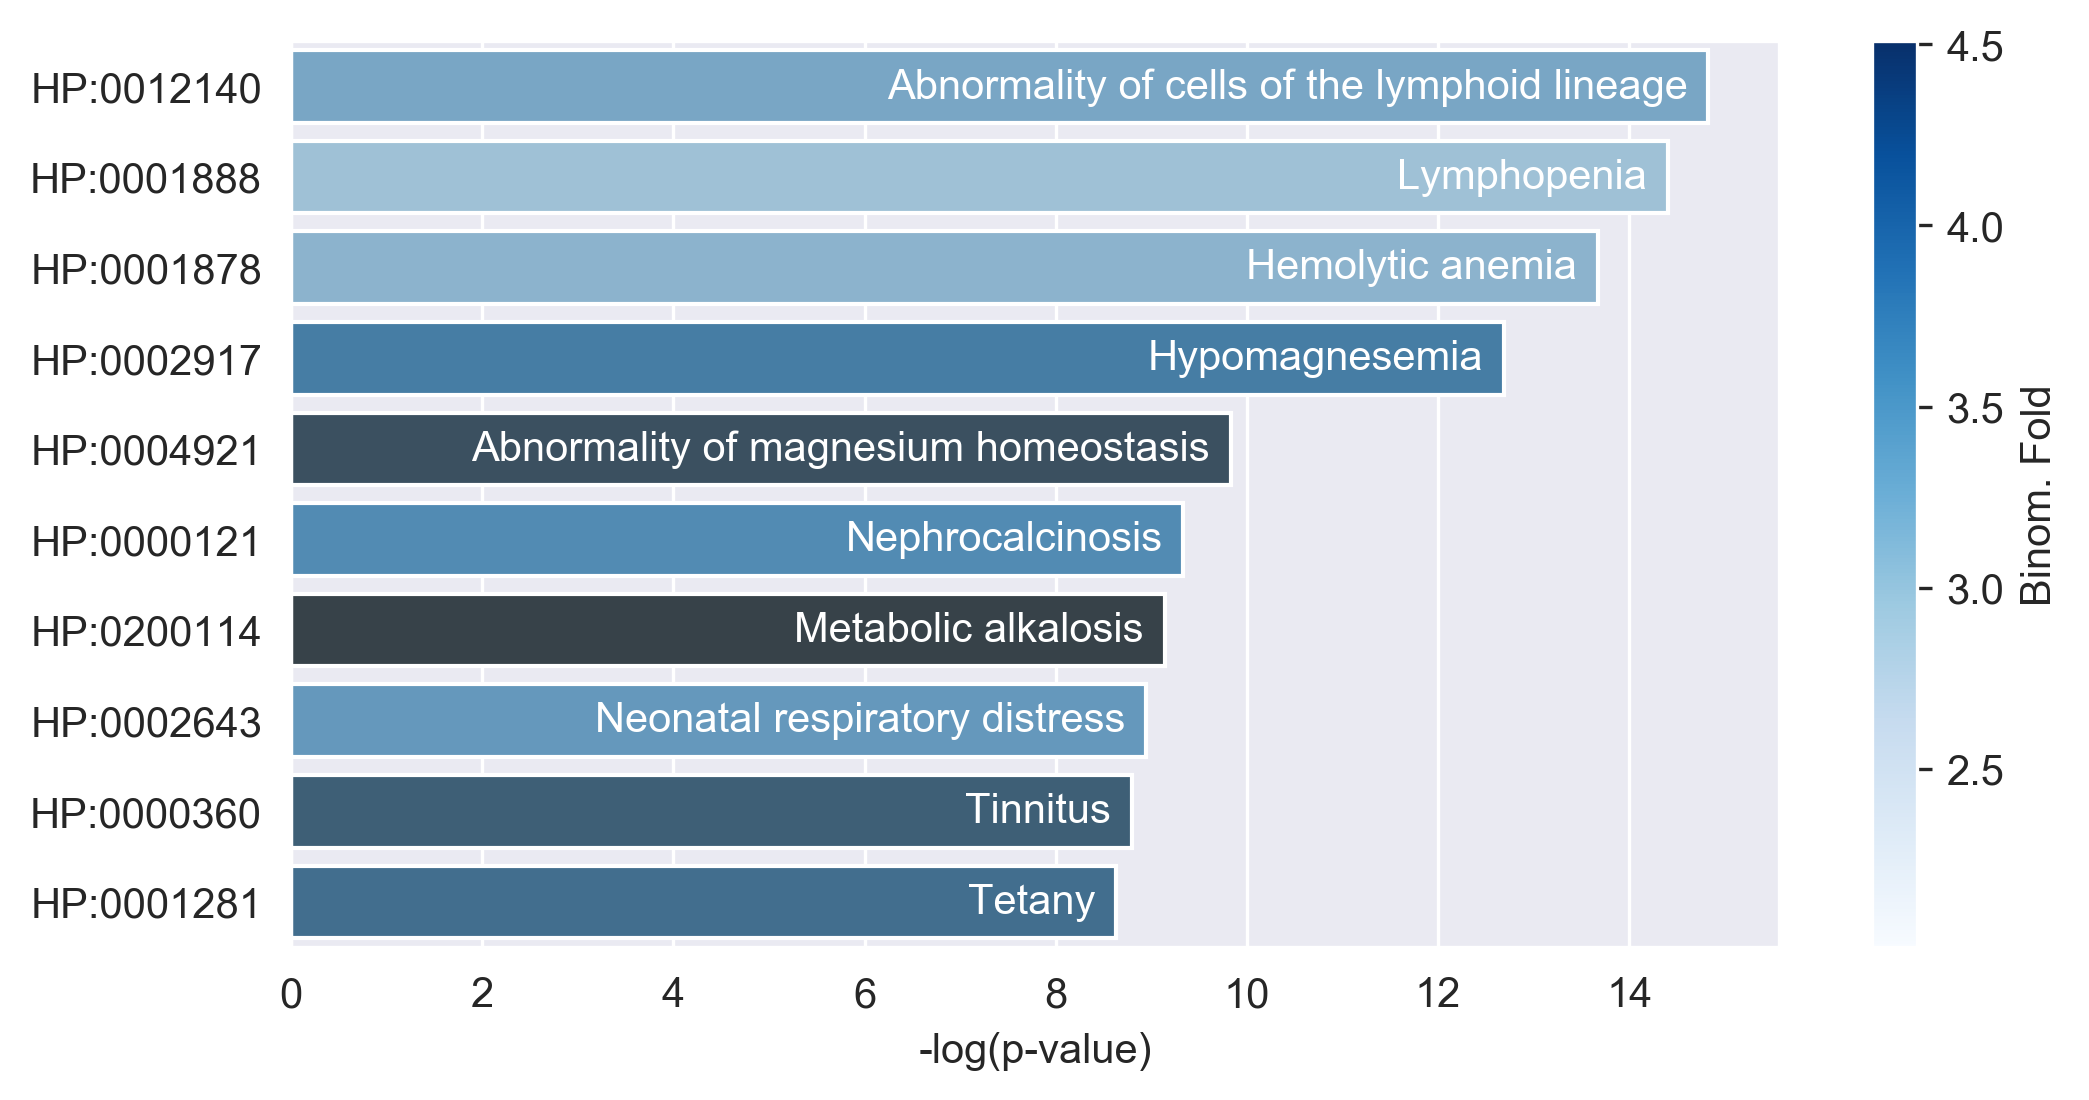

In [400]:
res = get_enrichment(get_top_pcs(phenotypes_of_interest[13])[0][0])
plot_enrichment_fig(res)

Phenotype:  Platelet count
Top PCs:  [0 1 3 2 9]


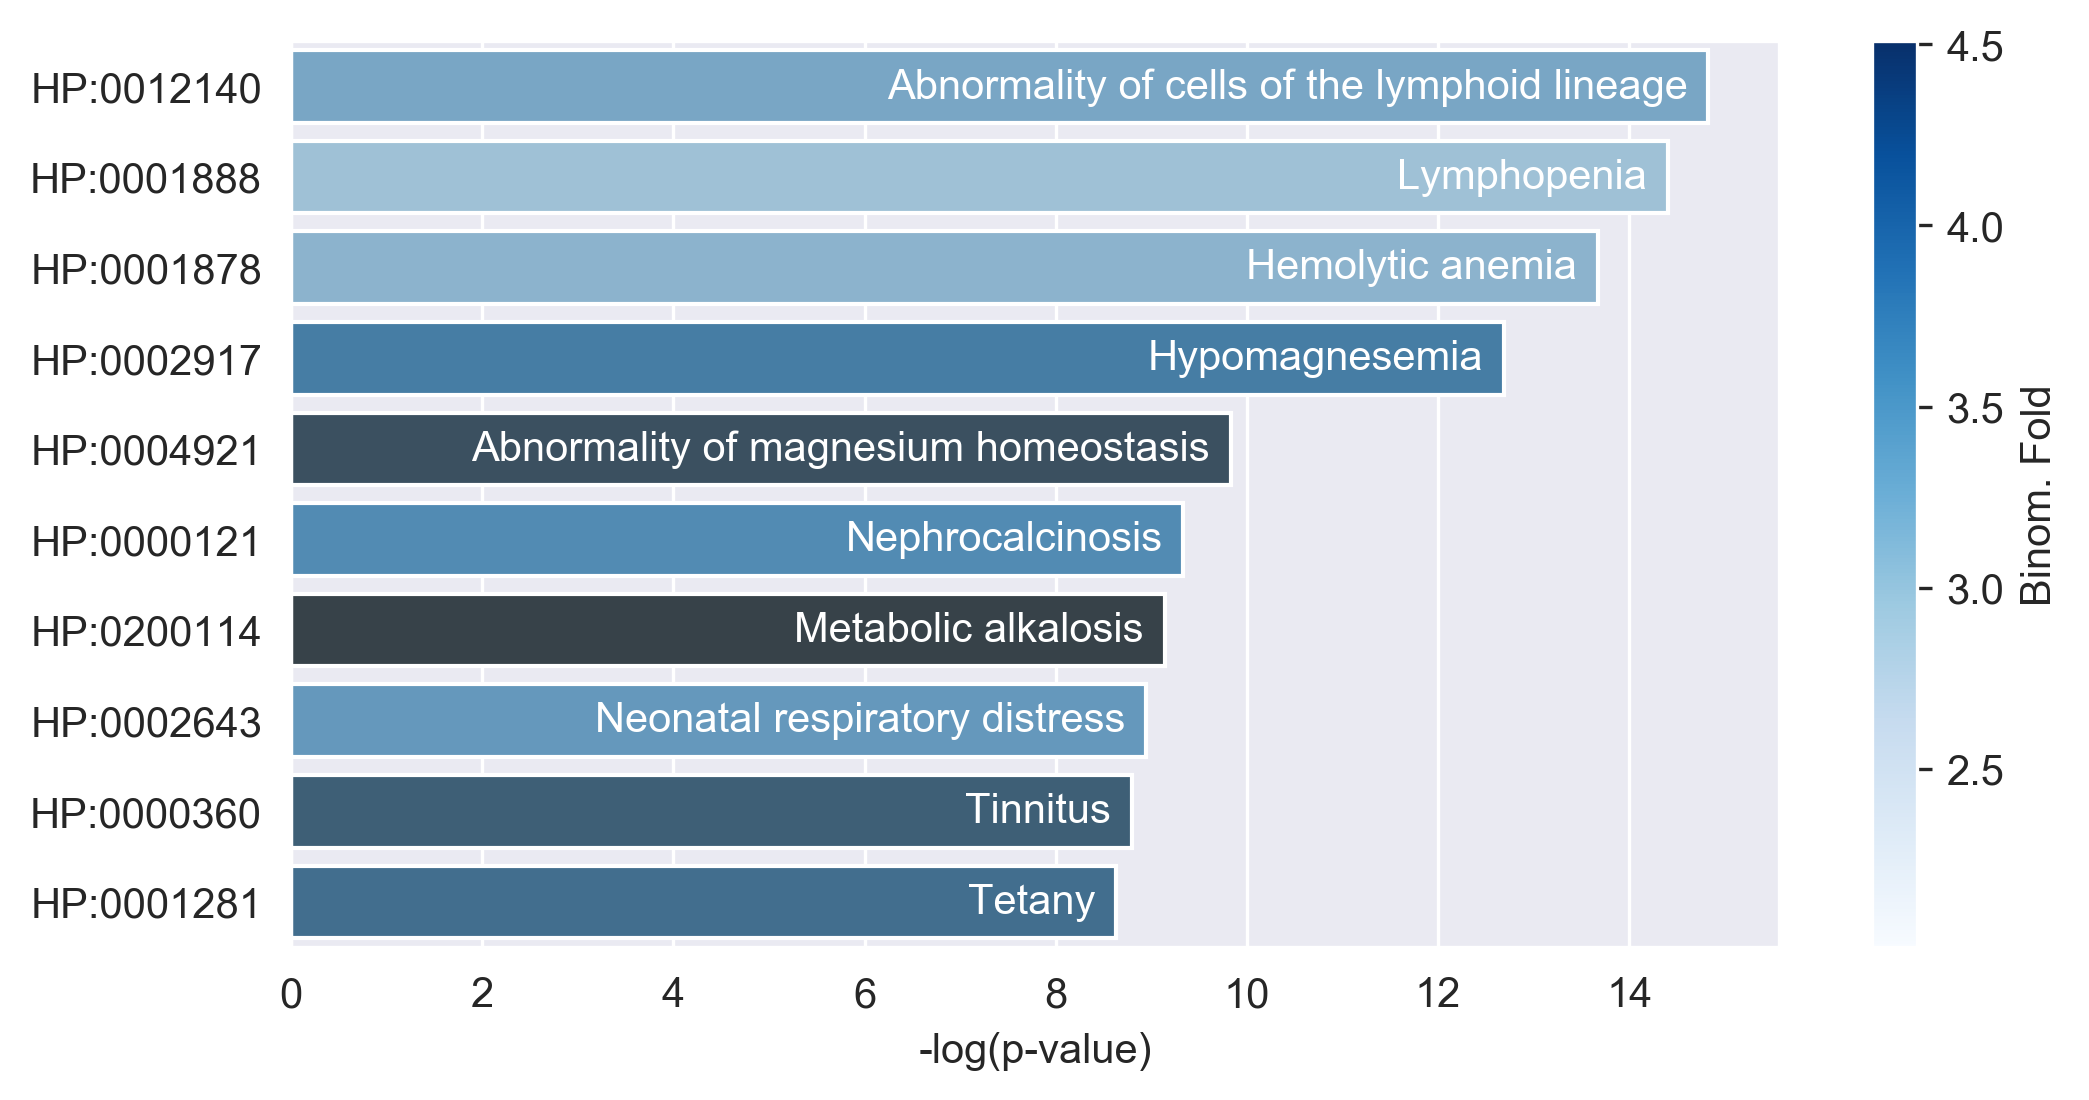

In [401]:
res = get_enrichment(get_top_pcs(phenotypes_of_interest[14])[0][0])
plot_enrichment_fig(res)